In [1]:
# https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
# https://towardsdatascience.com/who-is-your-golden-goose-cohort-analysis-50c9de5dbd31
# https://medium.com/supervised-learning-on-python-predicting-customer/supervised-learning-on-python-predicting-customer-churn-1-5d661b07715f
# https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
# https://towardsdatascience.com/customer-churn-analysis-4f77cc70b3bd

#Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import pyodbc
import squarify
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xverse.ensemble import VotingSelector
from sklearn.preprocessing import MinMaxScaler  
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")

In [2]:
# Connecting the the database
conn= pyodbc.connect("Driver={SQL Server};"
                      "Server=DESKTOP-ASSVM88;"
                      "Database=AdventureWorksDW2017;"
                      "Trusted_Connection=yes;")

In [3]:
# Importing from the products tables

pdts = pd.read_sql_query('''
select 
ProductKey as Product_ID,
EnglishProductName as Product_Name

from dbo.DimProduct

''', conn)

conn.close

<function Connection.close>

In [4]:
pdts.columns

Index(['Product_ID', 'Product_Name'], dtype='object')

In [5]:
#Importing relevant tables.
# Tables to be imported are customers, factinternetsales, promotion, sales territory and geography

#Fact Internet Sales table
fact_int_sales = pd.read_sql_query('''
select 
CustomerKey as Customer_ID,
ProductKey as Product_ID,
SalesOrderNumber as 'Order_Number',
SalesAmount,
OrderDate,
OrderQuantity,
PromotionKey,
SalesTerritoryKey
from dbo.factinternetsales
''', conn)
conn.close

<function Connection.close>

In [6]:
# Check the data imported
fact_int_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 8 columns):
Customer_ID          60398 non-null int64
Product_ID           60398 non-null int64
Order_Number         60398 non-null object
SalesAmount          60398 non-null float64
OrderDate            60398 non-null datetime64[ns]
OrderQuantity        60398 non-null int64
PromotionKey         60398 non-null int64
SalesTerritoryKey    60398 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 3.7+ MB


In [7]:
#Importing customer tablee

customer = pd.read_sql_query('''
select
CustomerKey as Customer_ID,
Datediff(Year,BirthDate,GetDate()) as Age,
Gender,
MaritalStatus,
YearlyIncome,
TotalChildren,
NumberChildrenAtHome,
EnglishEducation as Education,
EnglishOccupation as Occupation,
HouseOwnerFlag as House_Owner,
NumberCarsOwned,
CommuteDistance
from dbo.DimCustomer
''', conn)
conn.close

<function Connection.close>

In [8]:
#View the dataset
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 12 columns):
Customer_ID             18484 non-null int64
Age                     18484 non-null int64
Gender                  18484 non-null object
MaritalStatus           18484 non-null object
YearlyIncome            18484 non-null float64
TotalChildren           18484 non-null int64
NumberChildrenAtHome    18484 non-null int64
Education               18484 non-null object
Occupation              18484 non-null object
House_Owner             18484 non-null object
NumberCarsOwned         18484 non-null int64
CommuteDistance         18484 non-null object
dtypes: float64(1), int64(5), object(6)
memory usage: 1.7+ MB


In [9]:
#Importing the promotion table

promotion = pd.read_sql_query('''
select
PromotionKey,

EnglishPromotionType

from dbo.DimPromotion

''',conn)
conn.close

<function Connection.close>

In [10]:
#looking at the promotion data for null values
promotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
PromotionKey            16 non-null int64
EnglishPromotionType    16 non-null object
dtypes: int64(1), object(1)
memory usage: 384.0+ bytes


In [11]:
#Visualizing the data
promotion.head(4)

,PromotionKey,EnglishPromotionType
0,1,No Discount
1,2,Volume Discount
2,3,Volume Discount
3,4,Volume Discount


In [12]:
#Importing the sales territory data
sales_territory = pd.read_sql_query('''
select
SalesTerritoryKey,
SalesTerritoryCountry as Country,
SalesTerritoryGroup as Continent
from dbo.DimSalesTerritory
''', conn)
conn.close

<function Connection.close>

In [13]:
#checking the data for null values
sales_territory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
SalesTerritoryKey    11 non-null int64
Country              11 non-null object
Continent            11 non-null object
dtypes: int64(1), object(2)
memory usage: 392.0+ bytes


In [14]:
#See entries in the dataset
sales_territory.head()

,SalesTerritoryKey,Country,Continent
0,1,United States,North America
1,2,United States,North America
2,3,United States,North America
3,4,United States,North America
4,5,United States,North America


In [15]:
#Importing Sales Reason table

sales_reason = pd.read_sql_query('''
select
*
from dbo.DimSalesReason
''',conn)
conn.close

<function Connection.close>

In [16]:
#Checking the data for null values
sales_reason.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
SalesReasonKey             10 non-null int64
SalesReasonAlternateKey    10 non-null int64
SalesReasonName            10 non-null object
SalesReasonReasonType      10 non-null object
dtypes: int64(2), object(2)
memory usage: 448.0+ bytes


In [17]:
#Visualize the data
sales_reason.head()

,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,1,1,Price,Other
1,2,2,On Promotion,Promotion
2,3,3,Magazine Advertisement,Marketing
3,4,4,Television Advertisement,Marketing
4,5,5,Manufacturer,Other


In [18]:
#Importing Fact Internet Sales Reason
fact_int_sales_reason = pd.read_sql_query('''
select
SalesOrderNumber as 'Order_Number',
SalesReasonKey
from FactInternetSalesReason
''',conn)
conn.close

<function Connection.close>

In [19]:
#Reviewing the dataset for null values
fact_int_sales_reason.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64515 entries, 0 to 64514
Data columns (total 2 columns):
Order_Number      64515 non-null object
SalesReasonKey    64515 non-null int64
dtypes: int64(1), object(1)
memory usage: 1008.2+ KB


In [20]:
#viewing the dataset
fact_int_sales_reason.head()

,Order_Number,SalesReasonKey
0,SO43697,5
1,SO43697,9
2,SO43702,5
3,SO43702,9
4,SO43703,5


## RFM For the Dataset

In [21]:
#Pin the latest date
pin_date = fact_int_sales.OrderDate.max() + dt.timedelta(1)

In [22]:
#Calculating RFM values

rfm = fact_int_sales.groupby('Customer_ID'). agg({'OrderDate': lambda x: (pin_date - x.max()).days, 'Order_Number': 'count', 'SalesAmount':'sum'})



#Renaming columns

rfm.rename(columns={'OrderDate': 'Recency', 'Order_Number':'Frequency','SalesAmount':'Monetary'}, inplace =True)

rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
11000,271,8,8248.99
11001,50,11,6383.88
11002,340,4,8114.04
11003,264,9,8139.29
11004,273,6,8196.01


In [23]:
rfm.describe()

,Recency,Frequency,Monetary
count,18484.000000,18484.000000,18484.000000
mean,190.332450,3.267583,1588.329216
std,146.288729,2.620927,2124.231717
min,1.000000,1.000000,2.290000
25%,87.000000,2.000000,49.970000
50%,169.000000,3.000000,270.265000
75%,264.000000,4.000000,2511.275000
max,1127.000000,68.000000,13295.380000


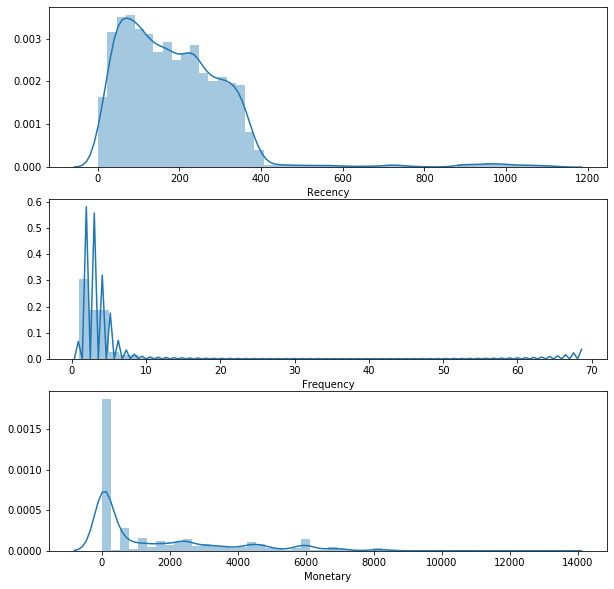

In [24]:
#Before creating the quartiles for the RFM, we need to see our distribution
#Plotting the RFM Distribution
plt.figure(figsize = (10,10))

#Plot distribution of R
plt.subplot(3,1,1);
sns.distplot(rfm['Recency'])

#Plot the distribution of F
plt.subplot(3,1,2);
sns.distplot(rfm['Frequency'])

#Plot distribution for M

plt.subplot(3,1,3);
sns.distplot(rfm['Monetary'])

plt.show()


In [25]:
#Checking the values in the Recency Bins

pd.qcut(rfm['Recency'], q=4)

Customer_ID
11000    (264.0, 1127.0]
11001      (0.999, 87.0]
11002    (264.0, 1127.0]
11003     (169.0, 264.0]
11004    (264.0, 1127.0]
              ...       
29479    (264.0, 1127.0]
29480     (169.0, 264.0]
29481    (264.0, 1127.0]
29482    (264.0, 1127.0]
29483    (264.0, 1127.0]
Name: Recency, Length: 18484, dtype: category
Categories (4, interval[float64]): [(0.999, 87.0] < (87.0, 169.0] < (169.0, 264.0] < (264.0, 1127.0]]

In [26]:
#grouping the RFM values into quartiles
#Create labels and assign to 3 percentile groups

r_labels = range(4,0,-1)
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

f_labels = range(1, 5)
f_groups = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)



In [27]:
# Make new columns for the group labels
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

#sum up the 3 columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis = 1)
                               
rfm.head()



,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer_ID,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0
11001,50,11,6383.88,4,4,4,444,12.0
11002,340,4,8114.04,1,3,4,134,8.0
11003,264,9,8139.29,2,4,4,244,10.0
11004,273,6,8196.01,1,4,4,144,9.0


In [28]:
#Calculate the average value for each RFM

rfm_agg =rfm.groupby('RFM_Score').agg({'Recency': 'mean',
                                       'Frequency': 'mean',
                                       'Monetary': ['mean', 'count']}).round(1)

rfm_agg.head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         315.3       1.6     22.9  1014
4.0         255.7       1.9     39.4  1490
5.0         258.4       2.0    473.5  2490
6.0         235.1       2.2    830.9  3022
7.0         178.0       2.9   1248.0  2508

In [29]:
#Assigning labels from total scores
score_labels = ['Bronze', 'Silver', 'Gold', 'Diamond']
score_groups = pd.qcut(rfm.RFM_Score, q=4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
Customer_ID,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Gold
11001,50,11,6383.88,4,4,4,444,12.0,Diamond
11002,340,4,8114.04,1,3,4,134,8.0,Gold
11003,264,9,8139.29,2,4,4,244,10.0,Diamond
11004,273,6,8196.01,1,4,4,144,9.0,Gold


In [30]:
# Viewing the RFM_Score and RFM_Level
rfm[['RFM_Score','RFM_Level']]

,RFM_Score,RFM_Level
Customer_ID,,
11000,9.0,Gold
11001,12.0,Diamond
11002,8.0,Gold
11003,10.0,Diamond
11004,9.0,Gold
...,...,...
29479,5.0,Bronze
29480,9.0,Gold
29481,6.0,Silver


In [31]:
#Confirming the numbers in different RFM_Levels
rfm.RFM_Level.value_counts()

Silver     5530
Bronze     4994
Gold       4670
Diamond    3290
Name: RFM_Level, dtype: int64

In [32]:
#Visualizing the different categories
rfm_level_agg = rfm.groupby('RFM_Level'). agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary':['mean','count']}). round(1)

print(rfm_level_agg)

          Recency Frequency Monetary      
             mean      mean     mean count
RFM_Level                                 
Bronze      269.1       1.9    252.5  4994
Silver      209.2       2.5   1020.1  5530
Gold        147.1       3.7   2044.7  4670
Diamond     100.2       6.1   3923.4  3290


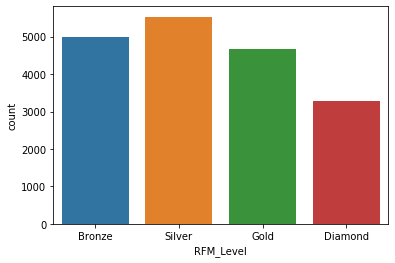

In [33]:
# Plotting the RFM_Level

sns.countplot(rfm['RFM_Level'])
plt.savefig('RFM Chart')
plt.show()

## K-Means Clustering

In [34]:
#Normalizing the RFM values
#Define functions for values below zero

def neg_to_zero(x):
    if x <=0:
        return 1
    else:
        return x
    
#appling this function to the Recency and Monetary column

rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]

#unskew the data
rfm_log = rfm[['Recency','Frequency', 'Monetary']]. apply(np.log, axis =1).round(3)

In [35]:
#Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

#transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns = rfm_log.columns)

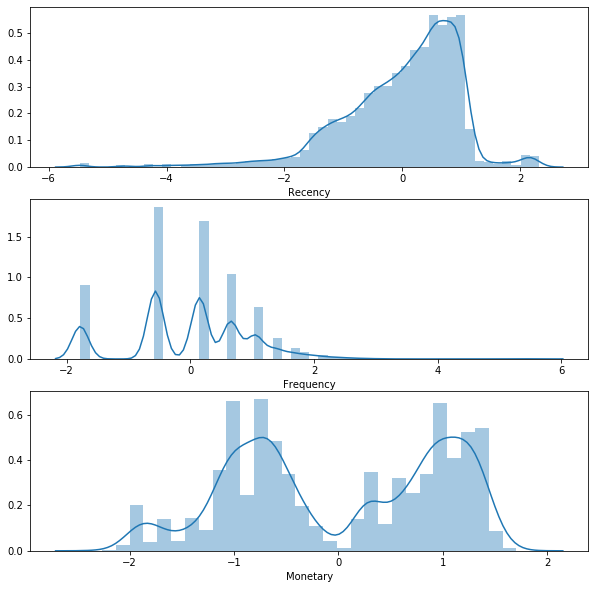

In [36]:
#Plotting the data after preprocessing
plt.figure(figsize = (10,10))

#Plot distribution of R
plt.subplot(3,1,1);
sns.distplot(rfm_scaled['Recency'])

#Plot the distribution of F
plt.subplot(3,1,2);
sns.distplot(rfm_scaled['Frequency'])

#Plot distribution for M

plt.subplot(3,1,3);
sns.distplot(rfm_scaled['Monetary'])

plt.show()

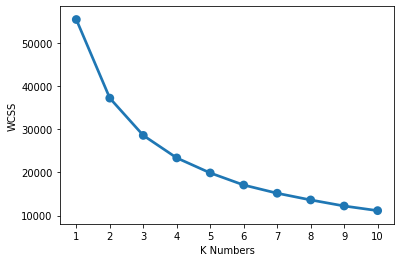

In [37]:
#Using the elbow method to determine the number of clusters

wcss = {}

for k in range(1,11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter =300)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_

#plotting the Wcss values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [38]:
# Clustering
clus = KMeans (n_clusters = 4, init = 'k-means++', max_iter = 300)

clus.fit(rfm_scaled)

# Assign the clusters to dataset

rfm['K_Cluster'] = clus.labels_

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
Customer_ID,,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Gold,0
11001,50,11,6383.88,4,4,4,444,12.0,Diamond,0
11002,340,4,8114.04,1,3,4,134,8.0,Gold,0
11003,264,9,8139.29,2,4,4,244,10.0,Diamond,0
11004,273,6,8196.01,1,4,4,144,9.0,Gold,0


In [39]:
rfm.K_Cluster.value_counts()

1    6600
0    6135
2    3432
3    2317
Name: K_Cluster, dtype: int64

In [40]:
### Comparing RFM Quartile and KMeans segmentations
#Assign cluster columns
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)

#melt the dataframe
rfm_melted = pd.melt(frame = rfm_scaled, id_vars= ['Customer_ID', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name ='Value')

rfm_melted.head()

,Customer_ID,RFM_Level,K_Cluster,Metrics,Value
0,11000,Gold,0,Recency,0.734276
1,11001,Diamond,0,Recency,-1.139147
2,11002,Gold,0,Recency,0.985913
3,11003,Diamond,0,Recency,0.705454
4,11004,Gold,0,Recency,0.742035


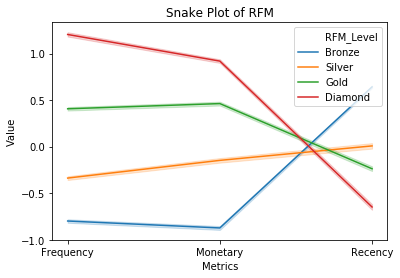

In [41]:
#A snake plot of RFM_Melted
sns.lineplot(x= 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)

plt.title('Snake Plot of RFM')
plt.legend(loc= 'upper right')


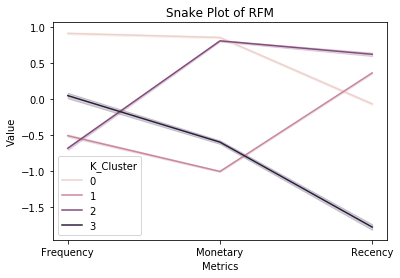

In [42]:
# Snake plot of K-Means
sns.lineplot( x ='Metrics', y='Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'best')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

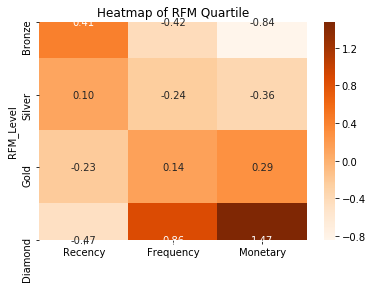

In [43]:
# Using Heat Map
# The mean value in total
total_avg = rfm.iloc[:, 0:3].mean()
total_avg

#calculate the proportional gap with total mean
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:,0:3]
prop_rfm = cluster_avg/total_avg -1

#heatmap with RFM
sns.heatmap(prop_rfm, cmap='Oranges', fmt= '.2f', annot=True)
plt.title('Heatmap of RFM Quartile')
plt.plot

[]

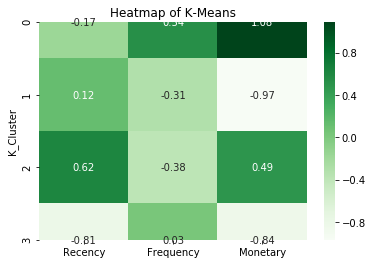

In [44]:
#Calculate the proportional gap with total mean
cluster_avg_k = rfm.groupby('K_Cluster').mean().iloc[:,0:3]
prop_rfm_k = cluster_avg_k/total_avg -1

#Heatmap with K-means
sns.heatmap(prop_rfm_k, cmap = 'Greens', fmt = '.2f', annot = True)

plt.title('Heatmap of K-Means')
plt.plot()

## Generating Single Customer view

In [45]:
#viewing the Fact_int_sales Dataset
fact_int_sales.head(5)

,Customer_ID,Product_ID,Order_Number,SalesAmount,OrderDate,OrderQuantity,PromotionKey,SalesTerritoryKey
0,21768,310,SO43697,3578.2700,2010-12-29,1,1,6
1,28389,346,SO43698,3399.9900,2010-12-29,1,1,7
2,25863,346,SO43699,3399.9900,2010-12-29,1,1,1
3,14501,336,SO43700,699.0982,2010-12-29,1,1,4
4,11003,346,SO43701,3399.9900,2010-12-29,1,1,9


In [46]:
#confirming unique entries in the dataset
fact_int_sales.nunique()

Customer_ID          18484
Product_ID             158
Order_Number         27659
SalesAmount             42
OrderDate             1124
OrderQuantity            1
PromotionKey             4
SalesTerritoryKey       10
dtype: int64

In [47]:
#Checking if there are empty rows in the dataset
fact_int_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 8 columns):
Customer_ID          60398 non-null int64
Product_ID           60398 non-null int64
Order_Number         60398 non-null object
SalesAmount          60398 non-null float64
OrderDate            60398 non-null datetime64[ns]
OrderQuantity        60398 non-null int64
PromotionKey         60398 non-null int64
SalesTerritoryKey    60398 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 3.7+ MB


In [48]:
#There are 60,398 entries with 18,484 unique customers.
# 158 unique products were on offer in the company.

mod_fact_int_sales = fact_int_sales.groupby(['Customer_ID','SalesTerritoryKey']).agg({'Order_Number': 'count','OrderDate': 'max', 'SalesAmount':'sum','PromotionKey':'max', 'Product_ID': 'max', 'OrderQuantity': 'sum'})


In [49]:
#viewing the dataset
mod_fact_int_sales.head()

,,Order_Number,OrderDate,SalesAmount,PromotionKey,Product_ID,OrderQuantity
Customer_ID,SalesTerritoryKey,,,,,,
11000,9,8,2013-05-03,8248.99,2,573,8
11001,9,11,2013-12-10,6383.88,1,604,11
11002,9,4,2013-02-23,8114.04,1,561,4
11003,9,9,2013-05-10,8139.29,1,564,9
11004,9,6,2013-05-01,8196.01,1,562,6


In [50]:
#reset the index
mod_fact_int_sales= mod_fact_int_sales.reset_index()

In [51]:
#Viewing the dataset
mod_fact_int_sales.head()

,Customer_ID,SalesTerritoryKey,Order_Number,OrderDate,SalesAmount,PromotionKey,Product_ID,OrderQuantity
0,11000,9,8,2013-05-03,8248.99,2,573,8
1,11001,9,11,2013-12-10,6383.88,1,604,11
2,11002,9,4,2013-02-23,8114.04,1,561,4
3,11003,9,9,2013-05-10,8139.29,1,564,9
4,11004,9,6,2013-05-01,8196.01,1,562,6


In [52]:
#Confirming the rows in the dataset
mod_fact_int_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 8 columns):
Customer_ID          18484 non-null int64
SalesTerritoryKey    18484 non-null int64
Order_Number         18484 non-null int64
OrderDate            18484 non-null datetime64[ns]
SalesAmount          18484 non-null float64
PromotionKey         18484 non-null int64
Product_ID           18484 non-null int64
OrderQuantity        18484 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 1.1 MB


## Joining the Customer Dataset to the Mod_fact_int_sales

In [53]:
#joining the customer dataset to the mod_fact_int_sales

expanded_data = pd.merge(mod_fact_int_sales,customer, on='Customer_ID')


In [54]:
#view dataset
expanded_data.head()

,Customer_ID,SalesTerritoryKey,Order_Number,OrderDate,SalesAmount,PromotionKey,Product_ID,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,House_Owner,NumberCarsOwned,CommuteDistance
0,11000,9,8,2013-05-03,8248.99,2,573,8,49,M,M,90000.0,2,0,Bachelors,Professional,1,0,1-2 Miles
1,11001,9,11,2013-12-10,6383.88,1,604,11,44,M,S,60000.0,3,3,Bachelors,Professional,0,1,0-1 Miles
2,11002,9,4,2013-02-23,8114.04,1,561,4,49,M,M,60000.0,3,3,Bachelors,Professional,1,1,2-5 Miles
3,11003,9,9,2013-05-10,8139.29,1,564,9,47,F,S,70000.0,0,0,Bachelors,Professional,0,1,5-10 Miles
4,11004,9,6,2013-05-01,8196.01,1,562,6,41,F,S,80000.0,5,5,Bachelors,Professional,1,4,1-2 Miles


In [55]:
#Viewing the rows in the dataset
expanded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 19 columns):
Customer_ID             18484 non-null int64
SalesTerritoryKey       18484 non-null int64
Order_Number            18484 non-null int64
OrderDate               18484 non-null datetime64[ns]
SalesAmount             18484 non-null float64
PromotionKey            18484 non-null int64
Product_ID              18484 non-null int64
OrderQuantity           18484 non-null int64
Age                     18484 non-null int64
Gender                  18484 non-null object
MaritalStatus           18484 non-null object
YearlyIncome            18484 non-null float64
TotalChildren           18484 non-null int64
NumberChildrenAtHome    18484 non-null int64
Education               18484 non-null object
Occupation              18484 non-null object
House_Owner             18484 non-null object
NumberCarsOwned         18484 non-null int64
CommuteDistance         18484 non-null object
dtypes: datetime6

In [56]:
# Join the product table to determine the last product purchased by the customers

expanded_data_ = pd.merge(expanded_data, pdts, on='Product_ID')

In [57]:
expanded_data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 20 columns):
Customer_ID             18484 non-null int64
SalesTerritoryKey       18484 non-null int64
Order_Number            18484 non-null int64
OrderDate               18484 non-null datetime64[ns]
SalesAmount             18484 non-null float64
PromotionKey            18484 non-null int64
Product_ID              18484 non-null int64
OrderQuantity           18484 non-null int64
Age                     18484 non-null int64
Gender                  18484 non-null object
MaritalStatus           18484 non-null object
YearlyIncome            18484 non-null float64
TotalChildren           18484 non-null int64
NumberChildrenAtHome    18484 non-null int64
Education               18484 non-null object
Occupation              18484 non-null object
House_Owner             18484 non-null object
NumberCarsOwned         18484 non-null int64
CommuteDistance         18484 non-null object
Product_Name     

In [58]:
expanded_data_.head(5)

,Customer_ID,SalesTerritoryKey,Order_Number,OrderDate,SalesAmount,PromotionKey,Product_ID,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,House_Owner,NumberCarsOwned,CommuteDistance,Product_Name
0,11000,9,8,2013-05-03,8248.99,2,573,8,49,M,M,90000.0,2,0,Bachelors,Professional,1,0,1-2 Miles,"Touring-1000 Blue, 46"
1,11058,9,6,2013-06-04,8248.02,1,573,6,55,M,M,80000.0,2,0,Partial College,Skilled Manual,1,2,1-2 Miles,"Touring-1000 Blue, 46"
2,11092,9,5,2013-06-21,8110.02,2,573,5,48,F,M,90000.0,2,2,Bachelors,Professional,1,0,1-2 Miles,"Touring-1000 Blue, 46"
3,11095,9,7,2013-06-25,8158.01,1,573,7,52,M,S,70000.0,1,0,Partial College,Skilled Manual,1,1,5-10 Miles,"Touring-1000 Blue, 46"
4,11107,9,6,2013-06-21,8171.01,1,573,6,44,F,M,90000.0,1,0,Bachelors,Professional,1,1,5-10 Miles,"Touring-1000 Blue, 46"


## Include other datasets for better analysis

In [59]:
#Join the sales_reason dataset with the fact_int_sales_reason data
#Look at the data
sales_reason.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
SalesReasonKey             10 non-null int64
SalesReasonAlternateKey    10 non-null int64
SalesReasonName            10 non-null object
SalesReasonReasonType      10 non-null object
dtypes: int64(2), object(2)
memory usage: 448.0+ bytes


In [60]:
#view the data
sales_reason.head()

,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,1,1,Price,Other
1,2,2,On Promotion,Promotion
2,3,3,Magazine Advertisement,Marketing
3,4,4,Television Advertisement,Marketing
4,5,5,Manufacturer,Other


In [61]:
#Check the columns in fact_int_sales_reason
fact_int_sales_reason.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64515 entries, 0 to 64514
Data columns (total 2 columns):
Order_Number      64515 non-null object
SalesReasonKey    64515 non-null int64
dtypes: int64(1), object(1)
memory usage: 1008.2+ KB


In [62]:
# Joining Sales Reason and fact internet sales reason
reason_for_sales = pd.merge(fact_int_sales_reason,sales_reason, on='SalesReasonKey', how = 'inner')


In [63]:
#Check out the rows of the new dataset

reason_for_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64515 entries, 0 to 64514
Data columns (total 5 columns):
Order_Number               64515 non-null object
SalesReasonKey             64515 non-null int64
SalesReasonAlternateKey    64515 non-null int64
SalesReasonName            64515 non-null object
SalesReasonReasonType      64515 non-null object
dtypes: int64(2), object(3)
memory usage: 3.0+ MB


In [64]:
#viewing the new dataset
reason_for_sales.head()

,Order_Number,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,5,5,Manufacturer,Other
1,SO43702,5,5,Manufacturer,Other
2,SO43703,5,5,Manufacturer,Other
3,SO43706,5,5,Manufacturer,Other
4,SO43707,5,5,Manufacturer,Other


In [65]:
#Confirming unique entries in the dataset
reason_for_sales.nunique()

Order_Number               23012
SalesReasonKey                 7
SalesReasonAlternateKey        7
SalesReasonName                7
SalesReasonReasonType          3
dtype: int64

In [66]:
#Dummifying the sales reason names to convert them to variables

d_reason = pd.get_dummies(reason_for_sales.SalesReasonName,columns=['Price', 'On Promotion', 'Magazine Advertisement','TV', 'Manufacturer', 'Review','Demo Event', 'Sponsorship', 'Quality', 'Other'])

In [67]:
# Viewing the dataset
d_reason.head()

,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [68]:
#Concatenate the dummified data and reason_for_sales

reason_data = pd.concat([reason_for_sales, d_reason], axis=1)

In [69]:
reason_data.head()

,Order_Number,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [70]:
reason_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64515 entries, 0 to 64514
Data columns (total 12 columns):
Order_Number                 64515 non-null object
SalesReasonKey               64515 non-null int64
SalesReasonAlternateKey      64515 non-null int64
SalesReasonName              64515 non-null object
SalesReasonReasonType        64515 non-null object
Manufacturer                 64515 non-null uint8
On Promotion                 64515 non-null uint8
Other                        64515 non-null uint8
Price                        64515 non-null uint8
Quality                      64515 non-null uint8
Review                       64515 non-null uint8
Television  Advertisement    64515 non-null uint8
dtypes: int64(2), object(3), uint8(7)
memory usage: 3.4+ MB


In [71]:
reason_data.sort_values(['Order_Number']).head()

,Order_Number,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1818,SO43697,9,9,Quality,Other,0,0,0,0,1,0,0
1819,SO43702,9,9,Quality,Other,0,0,0,0,1,0,0
1,SO43702,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [72]:
#Show unique salesreason name
sales_reason.SalesReasonName.unique()

array(['Price', 'On Promotion', 'Magazine Advertisement',
       'Television  Advertisement', 'Manufacturer', 'Review',
       'Demo Event', 'Sponsorship', 'Quality', 'Other'], dtype=object)

In [73]:
#Import the fact_int_sales dataset from the database

fctintsales=pd.read_sql_query('''
select
CustomerKey as 'Customer_ID',
SalesOrderNumber as 'Order_Number'

from dbo.FactInternetSales
''', conn)

conn.close

<function Connection.close>

In [74]:
#View the dataset
fctintsales.head()

,Customer_ID,Order_Number
0,21768,SO43697
1,28389,SO43698
2,25863,SO43699
3,14501,SO43700
4,11003,SO43701


In [75]:
#merge fstintsales to reason_data
reason_data_= pd.merge(fctintsales,reason_data, on='Order_Number')

In [76]:
#View the reason_data_ dataset
reason_data_.head()

,Customer_ID,Order_Number,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,21768,SO43697,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,21768,SO43697,9,9,Quality,Other,0,0,0,0,1,0,0
2,27645,SO43702,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,27645,SO43702,9,9,Quality,Other,0,0,0,0,1,0,0
4,16624,SO43703,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [77]:
#Aggregate the sales reason in single customer view

reason_data_ = reason_data_.groupby('Customer_ID'). agg({'Manufacturer':'max','On Promotion':'max', 'Other':'max', 'Price':'max', 'Quality':'max', 'Review':'max','Television  Advertisement':'max'}) .reset_index()

In [78]:
#viewing the dataset
reason_data_.head()

,Customer_ID,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [79]:
#merge the expanded_ data to the reason_data_

expanded_ = pd.merge(expanded_data_,reason_data_, on='Customer_ID', how = 'left')



In [80]:
# See what the data is like
expanded_.head()

,Customer_ID,SalesTerritoryKey,Order_Number,OrderDate,SalesAmount,PromotionKey,Product_ID,OrderQuantity,Age,Gender,...,NumberCarsOwned,CommuteDistance,Product_Name,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,9,8,2013-05-03,8248.99,2,573,8,49,M,...,0,1-2 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,11058,9,6,2013-06-04,8248.02,1,573,6,55,M,...,2,1-2 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,11092,9,5,2013-06-21,8110.02,2,573,5,48,F,...,0,1-2 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,11095,9,7,2013-06-25,8158.01,1,573,7,52,M,...,1,5-10 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,11107,9,6,2013-06-21,8171.01,1,573,6,44,F,...,1,5-10 Miles,"Touring-1000 Blue, 46",0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [81]:
#View the dataset
expanded_.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 27 columns):
Customer_ID                  18484 non-null int64
SalesTerritoryKey            18484 non-null int64
Order_Number                 18484 non-null int64
OrderDate                    18484 non-null datetime64[ns]
SalesAmount                  18484 non-null float64
PromotionKey                 18484 non-null int64
Product_ID                   18484 non-null int64
OrderQuantity                18484 non-null int64
Age                          18484 non-null int64
Gender                       18484 non-null object
MaritalStatus                18484 non-null object
YearlyIncome                 18484 non-null float64
TotalChildren                18484 non-null int64
NumberChildrenAtHome         18484 non-null int64
Education                    18484 non-null object
Occupation                   18484 non-null object
House_Owner                  18484 non-null object
NumberCarsOwned        

In [82]:
#Add promotion dataset to the expanded_ data
expanded_more = pd.merge(expanded_,promotion, on= 'PromotionKey', how = 'left')


In [83]:
#View the number of rows in the new dataset
expanded_more.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 28 columns):
Customer_ID                  18484 non-null int64
SalesTerritoryKey            18484 non-null int64
Order_Number                 18484 non-null int64
OrderDate                    18484 non-null datetime64[ns]
SalesAmount                  18484 non-null float64
PromotionKey                 18484 non-null int64
Product_ID                   18484 non-null int64
OrderQuantity                18484 non-null int64
Age                          18484 non-null int64
Gender                       18484 non-null object
MaritalStatus                18484 non-null object
YearlyIncome                 18484 non-null float64
TotalChildren                18484 non-null int64
NumberChildrenAtHome         18484 non-null int64
Education                    18484 non-null object
Occupation                   18484 non-null object
House_Owner                  18484 non-null object
NumberCarsOwned        

In [84]:
#Check out the records

expanded_more.head()

,Customer_ID,SalesTerritoryKey,Order_Number,OrderDate,SalesAmount,PromotionKey,Product_ID,OrderQuantity,Age,Gender,...,CommuteDistance,Product_Name,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType
0,11000,9,8,2013-05-03,8248.99,2,573,8,49,M,...,1-2 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount
1,11058,9,6,2013-06-04,8248.02,1,573,6,55,M,...,1-2 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,0.0,0.0,0.0,0.0,No Discount
2,11092,9,5,2013-06-21,8110.02,2,573,5,48,F,...,1-2 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount
3,11095,9,7,2013-06-25,8158.01,1,573,7,52,M,...,5-10 Miles,"Touring-1000 Blue, 46",0.0,1.0,0.0,1.0,0.0,0.0,0.0,No Discount
4,11107,9,6,2013-06-21,8171.01,1,573,6,44,F,...,5-10 Miles,"Touring-1000 Blue, 46",0.0,0.0,0.0,1.0,0.0,0.0,0.0,No Discount


In [85]:
# Include Sales territory dataset

expanded_max =pd.merge(expanded_more,sales_territory, on='SalesTerritoryKey')



In [86]:
#check out the columns
expanded_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 30 columns):
Customer_ID                  18484 non-null int64
SalesTerritoryKey            18484 non-null int64
Order_Number                 18484 non-null int64
OrderDate                    18484 non-null datetime64[ns]
SalesAmount                  18484 non-null float64
PromotionKey                 18484 non-null int64
Product_ID                   18484 non-null int64
OrderQuantity                18484 non-null int64
Age                          18484 non-null int64
Gender                       18484 non-null object
MaritalStatus                18484 non-null object
YearlyIncome                 18484 non-null float64
TotalChildren                18484 non-null int64
NumberChildrenAtHome         18484 non-null int64
Education                    18484 non-null object
Occupation                   18484 non-null object
House_Owner                  18484 non-null object
NumberCarsOwned        

In [87]:
#View the dataset
expanded_max.head()

,Customer_ID,SalesTerritoryKey,Order_Number,OrderDate,SalesAmount,PromotionKey,Product_ID,OrderQuantity,Age,Gender,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent
0,11000,9,8,2013-05-03,8248.99,2,573,8,49,M,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific
1,11058,9,6,2013-06-04,8248.02,1,573,6,55,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,No Discount,Australia,Pacific
2,11092,9,5,2013-06-21,8110.02,2,573,5,48,F,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific
3,11095,9,7,2013-06-25,8158.01,1,573,7,52,M,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific
4,11107,9,6,2013-06-21,8171.01,1,573,6,44,F,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific


In [88]:
# Drop Sales territory, promotion and product keys since we have the territory and promotion names
expanded_max.drop(['SalesTerritoryKey','PromotionKey', 'Product_ID'], axis=1, inplace = True)

In [89]:
# Sort the data by customer ID
expanded_max['Customer_ID'].sort_values()
expanded_max.head()

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent
0,11000,8,2013-05-03,8248.99,8,49,M,M,90000.0,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific
1,11058,6,2013-06-04,8248.02,6,55,M,M,80000.0,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,No Discount,Australia,Pacific
2,11092,5,2013-06-21,8110.02,5,48,F,M,90000.0,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific
3,11095,7,2013-06-25,8158.01,7,52,M,S,70000.0,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific
4,11107,6,2013-06-21,8171.01,6,44,F,M,90000.0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific


In [90]:
expanded_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 27 columns):
Customer_ID                  18484 non-null int64
Order_Number                 18484 non-null int64
OrderDate                    18484 non-null datetime64[ns]
SalesAmount                  18484 non-null float64
OrderQuantity                18484 non-null int64
Age                          18484 non-null int64
Gender                       18484 non-null object
MaritalStatus                18484 non-null object
YearlyIncome                 18484 non-null float64
TotalChildren                18484 non-null int64
NumberChildrenAtHome         18484 non-null int64
Education                    18484 non-null object
Occupation                   18484 non-null object
House_Owner                  18484 non-null object
NumberCarsOwned              18484 non-null int64
CommuteDistance              18484 non-null object
Product_Name                 18484 non-null object
Manufacturer         

## Addressing Churn

In [91]:
#Finding the max date in the dataset
last_date = expanded_max.OrderDate.max()
last_date

Timestamp('2014-01-28 00:00:00')

In [92]:
#Churn is for those that haven't bought in the last 8 months
# churn date will be 29/05/2013, that is 8 months prior the last date in the dataset
churn_date = pd.to_datetime('29-05-2013')
churn_date

Timestamp('2013-05-29 00:00:00')

In [93]:
#Finding the records that have churned
churn = expanded_max.OrderDate < churn_date
churn

0         True
1        False
2        False
3        False
4        False
         ...  
18479    False
18480     True
18481     True
18482     True
18483    False
Name: OrderDate, Length: 18484, dtype: bool

In [94]:
#passing this into the dataset as a new variable 'Churned'

expanded_max['Churned'] = churn

#Viewing the new dataset
expanded_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 28 columns):
Customer_ID                  18484 non-null int64
Order_Number                 18484 non-null int64
OrderDate                    18484 non-null datetime64[ns]
SalesAmount                  18484 non-null float64
OrderQuantity                18484 non-null int64
Age                          18484 non-null int64
Gender                       18484 non-null object
MaritalStatus                18484 non-null object
YearlyIncome                 18484 non-null float64
TotalChildren                18484 non-null int64
NumberChildrenAtHome         18484 non-null int64
Education                    18484 non-null object
Occupation                   18484 non-null object
House_Owner                  18484 non-null object
NumberCarsOwned              18484 non-null int64
CommuteDistance              18484 non-null object
Product_Name                 18484 non-null object
Manufacturer         

## Visualizing Churn Against Several Variables And Revenue.

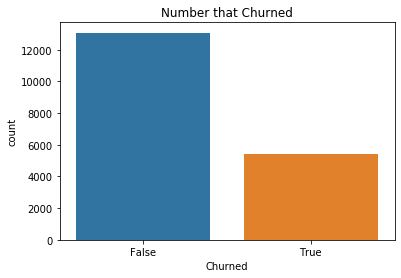

In [95]:
# let's see how many people churned in the dataset
sns.countplot(expanded_max['Churned'])
plt.title('Number that Churned')
plt.savefig('Churned Vs Not Churned')

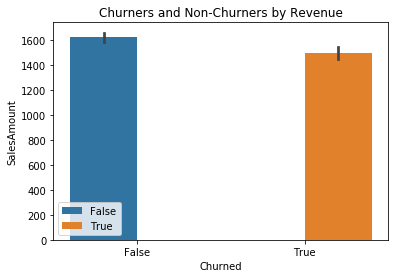

In [96]:
# Comparing revenue from those that churned and those who didn't
sns.barplot(x='Churned', y= 'SalesAmount', hue='Churned', data=expanded_max)
plt.title('Churners and Non-Churners by Revenue')
plt.legend(loc='best')
plt.savefig('Churners and Non-Churners by Revenue.png')

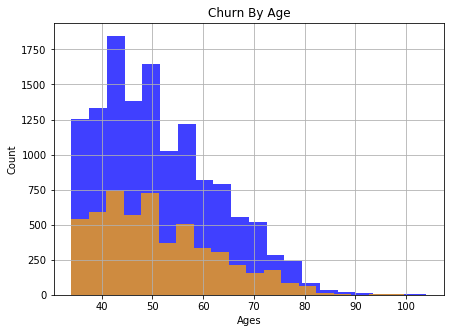

In [97]:
#Churn by Age
numerical_feature = ['Age']
fig, ax = plt.subplots(1, figsize = (7,5))
expanded_max[expanded_max['Churned']==False][numerical_feature].hist(bins = 20, color = 'blue', alpha = 0.75, ax=ax)
expanded_max[expanded_max['Churned']==True][numerical_feature].hist(bins = 20, color = 'orange', alpha = 0.75, ax=ax)
plt.xlabel('Ages')
plt.title('Churn By Age')
plt.ylabel("Count")
plt.savefig('Churn By Ages.png')


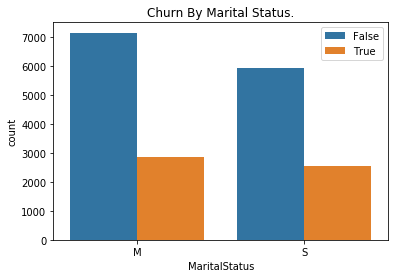

In [98]:
#Visualize Churn by marital staus
sns.countplot(x='MaritalStatus', hue='Churned', data = expanded_max)
plt.title('Churn By Marital Status.')
plt.legend(loc='best')
plt.savefig('Churn by Marital Status.png')

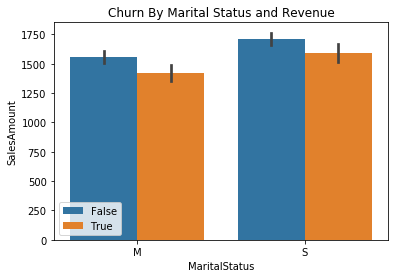

In [99]:
#Visualize possible revenue of possible churn by marital staus
sns.barplot(data = expanded_max, hue= 'Churned', x = 'MaritalStatus', y = 'SalesAmount')
plt.title('Churn By Marital Status and Revenue')
plt.legend(loc='best')
plt.savefig('Churn by Marital Status & Reve.png')

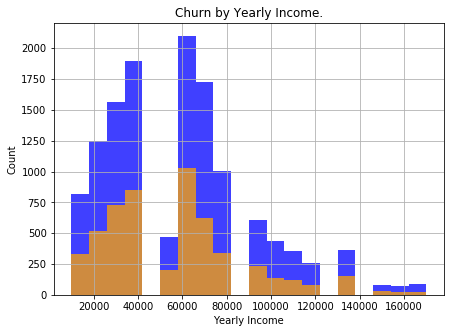

In [100]:
#Churn by Yearly Income
numerical_feature = ['YearlyIncome']
fig, ax = plt.subplots(1, figsize = (7,5))
expanded_max[expanded_max['Churned']==False][numerical_feature].hist(bins = 20, color = 'blue', alpha = 0.75, ax=ax)
expanded_max[expanded_max['Churned']==True][numerical_feature].hist(bins = 20, color = 'orange', alpha = 0.75, ax=ax)
plt.xlabel('Yearly Income')
plt.ylabel("Count")
plt.title('Churn by Yearly Income.')
plt.savefig('Churn By Yearly Income.png')


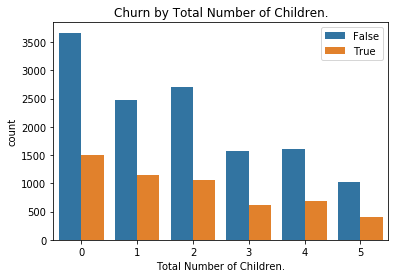

In [101]:
#Churn by total children
sns.countplot(x='TotalChildren', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn by Total Number of Children.')
plt.xlabel('Total Number of Children.')
plt.savefig('Churn By Total Children.png')

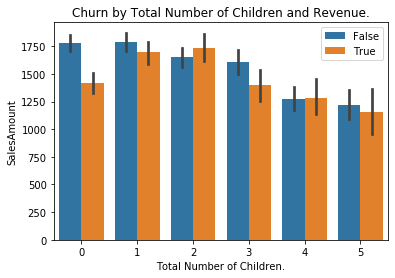

In [102]:
#Churn by total children and revenue
sns.barplot(x='TotalChildren', y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn by Total Number of Children and Revenue.')
plt.xlabel('Total Number of Children.')
plt.savefig('Churn By Total Children and Sales Amount.png')

Text(0.5, 1, 'Churn by Number of Children.')

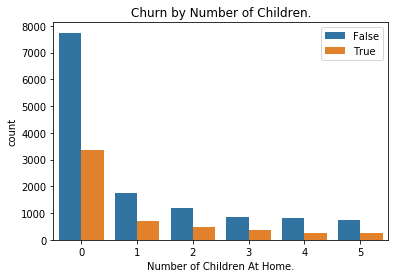

In [103]:
#Churn by Number of Children at home
sns.countplot(x='NumberChildrenAtHome', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.savefig('Churn By Number of Children at Home.png')
plt.xlabel('Number of Children At Home.')
plt.title('Churn by Number of Children.')

Text(0.5, 1, 'Churn by Number of Children and Revenue')

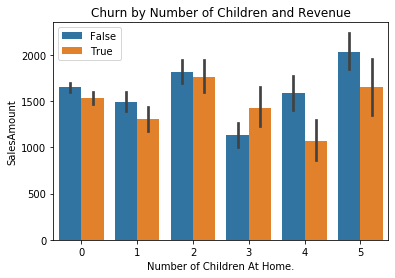

In [104]:
#Churn by Number of Children at home and Sales Amount
sns.barplot(x='NumberChildrenAtHome',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.savefig('Churn By Number of Children at Home and Revenue.png')
plt.xlabel('Number of Children At Home.')
plt.title('Churn by Number of Children and Revenue')

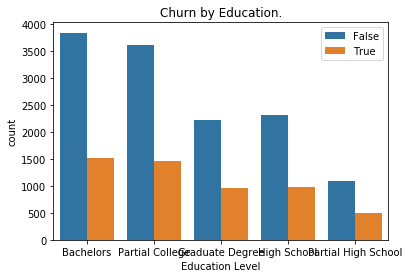

In [105]:
# Churn by Education Level
sns.countplot(x='Education', hue='Churned', data =expanded_max)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["xtick.labelsize"] = 7
plt.legend(loc='best')
plt.title('Churn by Education.')
plt.xlabel('Education Level')
plt.savefig('Churn By Level of Education.png')

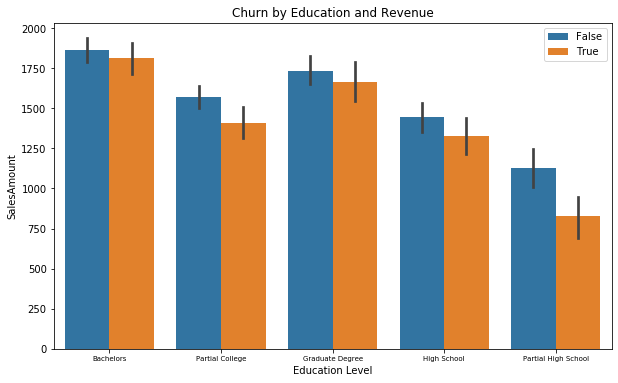

In [106]:
# Churn by Education Level and Revenue
sns.barplot(x='Education',y='SalesAmount', hue='Churned', data =expanded_max)
plt.rcParams['figure.figsize']= (10,6)
plt.rcParams['xtick.labelsize'] = 7
plt.legend(loc='best')
plt.title('Churn by Education and Revenue')
plt.xlabel('Education Level')
plt.savefig('Churn By Level of Education and Revenue.png')

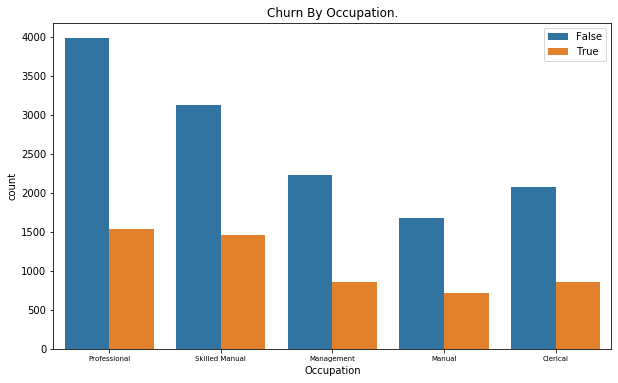

In [107]:
# Churn by Occupation
sns.countplot(x='Occupation', hue='Churned', data =expanded_max)
plt.rcParams['figure.figsize']= (10,6)
plt.rcParams['xtick.labelsize']= 14
plt.legend(loc='best')
plt.xlabel('Occupation')
plt.title('Churn By Occupation.')
plt.savefig('Churn By Occupation.png')

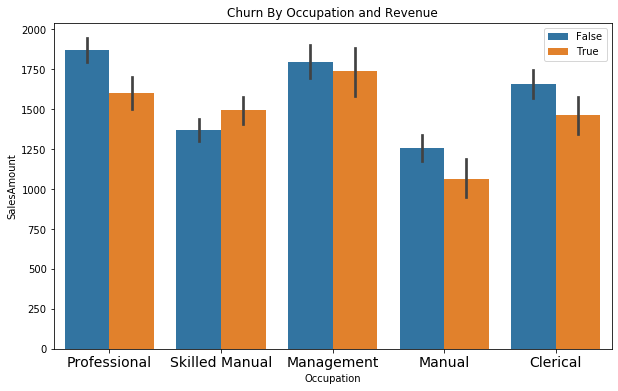

In [108]:
# Churn by Occupation
sns.barplot(x='Occupation', y = 'SalesAmount', hue='Churned', data =expanded_max)
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['xtick.labelsize']=14
plt.legend(loc='best')
plt.xlabel('Occupation')
plt.title('Churn By Occupation and Revenue')
plt.savefig('Churn By Occupation and Revenue.png')

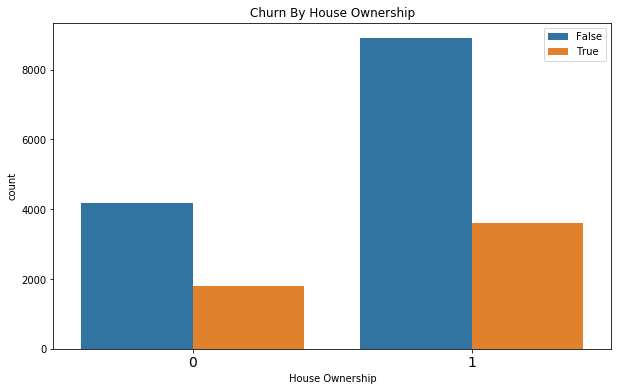

In [109]:
#Churn by House Ownership
sns.countplot(x='House_Owner', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.xlabel('House Ownership')
plt.title('Churn By House Ownership')
plt.savefig('Churn By House Owner.png')

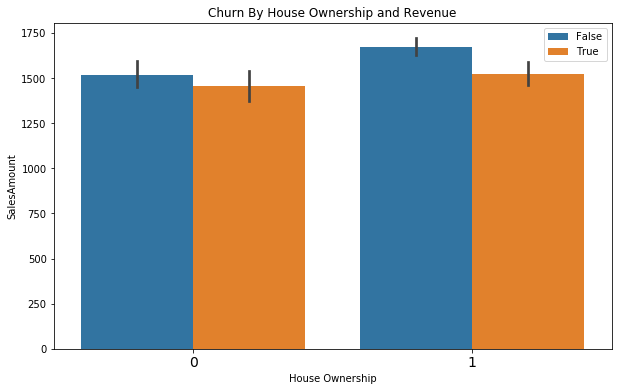

In [110]:
#Churn by House Ownership
sns.barplot(x='House_Owner', y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.xlabel('House Ownership')
plt.title('Churn By House Ownership and Revenue')
plt.savefig('Churn By House Owner and Revenue.png')

Text(0.5, 29.0, 'Number of Cars Owned')

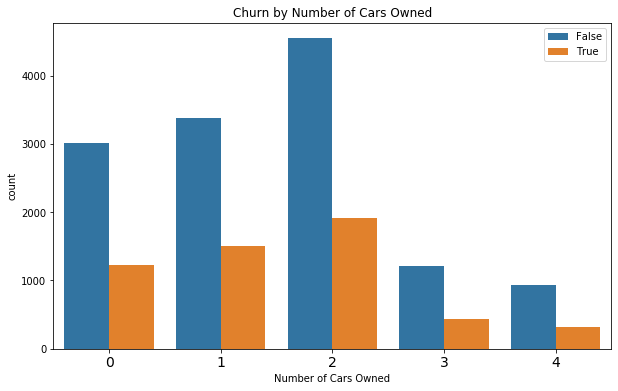

In [111]:
#Churn by Number of cars owned
sns.countplot(x='NumberCarsOwned', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.savefig('Churn By Number of Cars Owned.png')
plt.title('Churn by Number of Cars Owned')
plt.xlabel('Number of Cars Owned')

Text(0.5, 29.0, 'Number of Cars Owned')

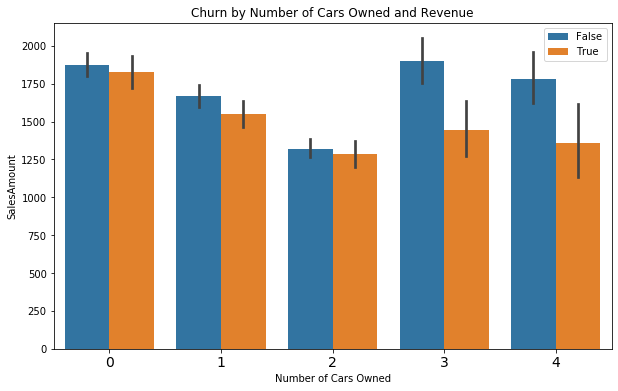

In [112]:
#Churn by Number of cars owned
sns.barplot(x='NumberCarsOwned',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.savefig('Churn By Number of Cars Owned and Revenue.png')
plt.title('Churn by Number of Cars Owned and Revenue')
plt.xlabel('Number of Cars Owned')

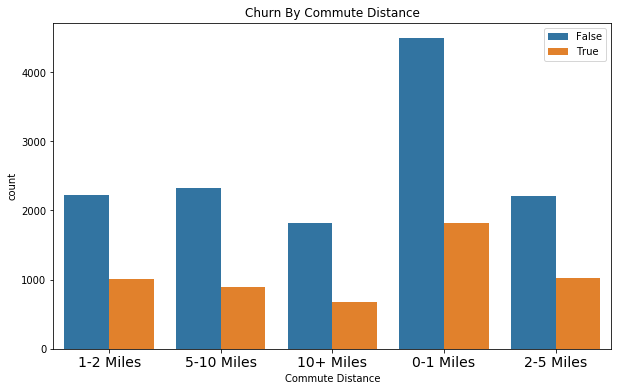

In [113]:
#Churn by Commute Distance
sns.countplot(x='CommuteDistance', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Commute Distance')
plt.xlabel('Commute Distance')
plt.savefig('Churn By Commute Distance.png')

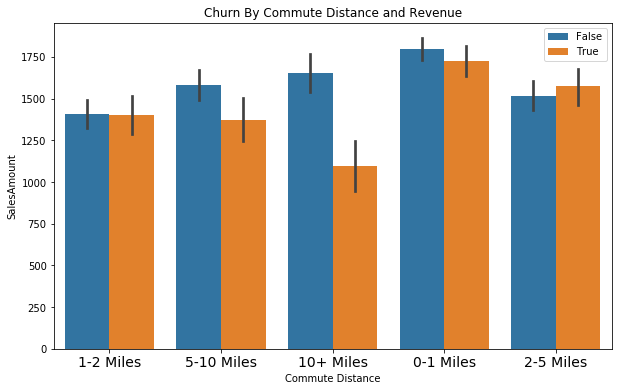

In [114]:
#Churn by Commute Distance and Revenue
sns.barplot(x='CommuteDistance',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Commute Distance and Revenue')
plt.xlabel('Commute Distance')
plt.savefig('Churn By Commute Distance and Revenue.png')

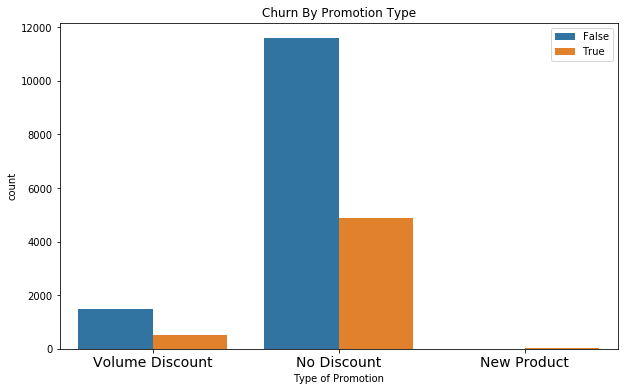

In [115]:
#Churn by Promotion Type
sns.countplot(x='EnglishPromotionType', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Promotion Type')
plt.xlabel('Type of Promotion')
plt.savefig('Churn By Promotion Type.png')

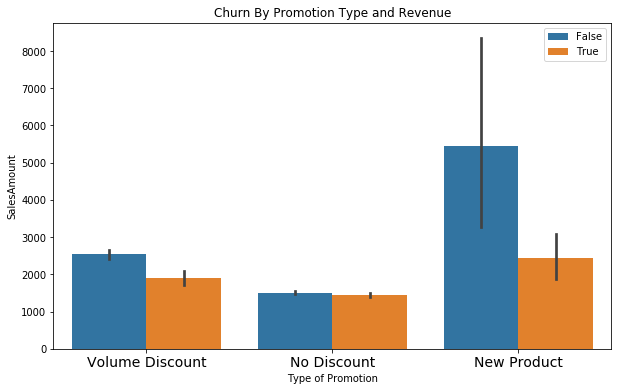

In [116]:
#Churn by Promotion Type
sns.barplot(x='EnglishPromotionType', y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Promotion Type and Revenue')
plt.xlabel('Type of Promotion')
plt.savefig('Churn By Promotion Type and Revenue.png')

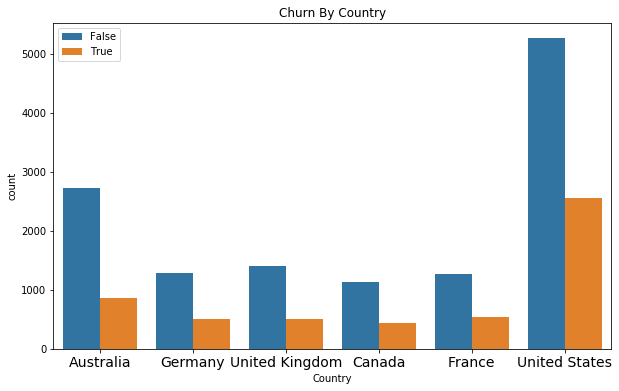

In [117]:
#Churn by Country
sns.countplot(x='Country', hue='Churned', data =expanded_max)
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['xtick.labelsize'] = 9
plt.legend(loc='best')
plt.title('Churn By Country')
plt.savefig('Churn By Country.png')

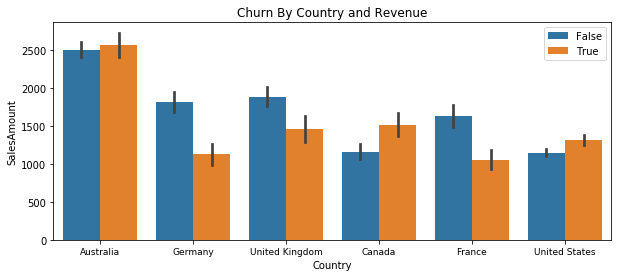

In [118]:
#Churn by Country
sns.barplot(x='Country',y='SalesAmount', hue='Churned', data =expanded_max)
plt.rcParams['figure.figsize']=(10,4)
plt.rcParams['xtick.labelsize']= 9
plt.legend(loc='best')
plt.title('Churn By Country and Revenue')
plt.savefig('Churn By Country and Revenue.png')

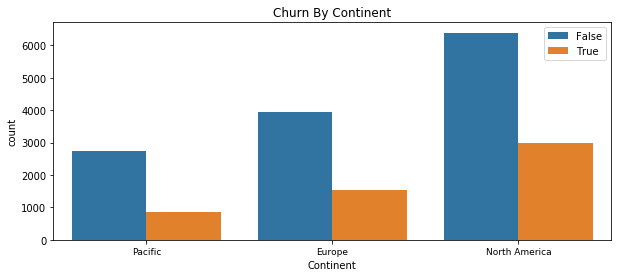

In [119]:
#Churn by Continent
sns.countplot(x='Continent', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Continent')
plt.savefig('Churn By Continent.png')

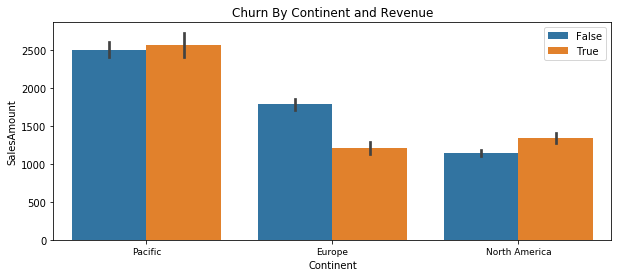

In [120]:
#Churn by Continent
sns.barplot(x='Continent',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Continent and Revenue')
plt.savefig('Churn By Continent and Revenue.png')

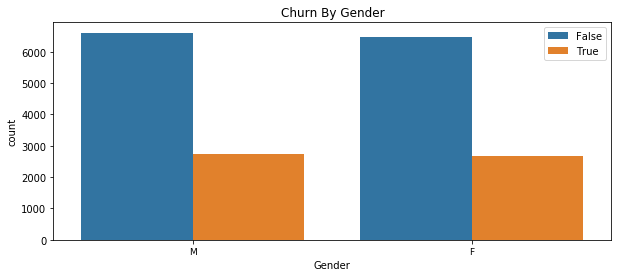

In [121]:
#Churn by Gender
sns.countplot(x='Gender', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Gender')
plt.savefig('Churn By Gender.png')

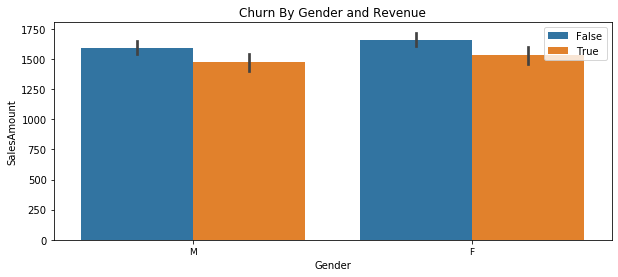

In [122]:
#Churn by Gender
sns.barplot(x='Gender', y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn By Gender and Revenue')
plt.savefig('Churn By Gender and Revenue.png')

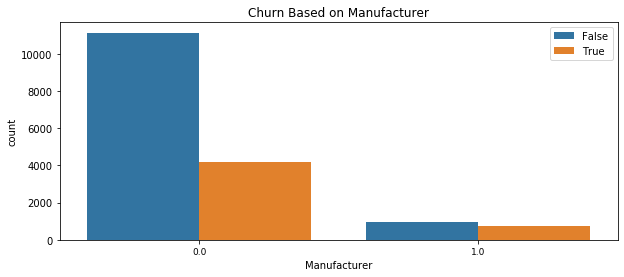

In [123]:
#Churn due to Manufacturer
sns.countplot(x='Manufacturer', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Manufacturer')
plt.savefig('Churn Due to Manufacturer.png')

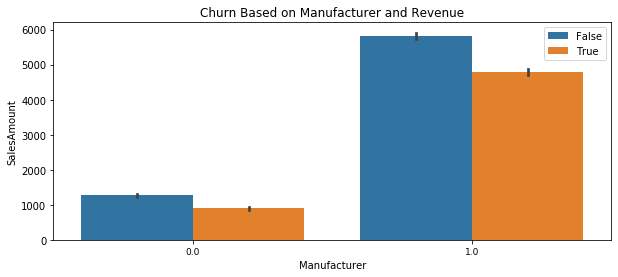

In [124]:
#Churn due to Manufacturer and Revenue
sns.barplot(x='Manufacturer',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Manufacturer and Revenue')
plt.savefig('Churn Due to Manufacturer and Revenue.png')

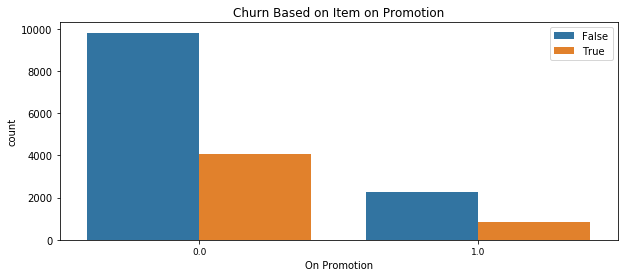

In [125]:
#Churn due to item on Promotion
sns.countplot(x='On Promotion', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Item on Promotion')
plt.savefig('Churn Due to Item Promotion.png')


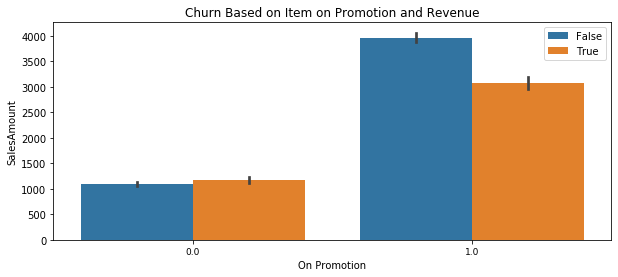

In [126]:
#Churn due to item on Promotion
sns.barplot(x='On Promotion',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Item on Promotion and Revenue')
plt.savefig('Churn Due to Item Promotion and Revenue.png')

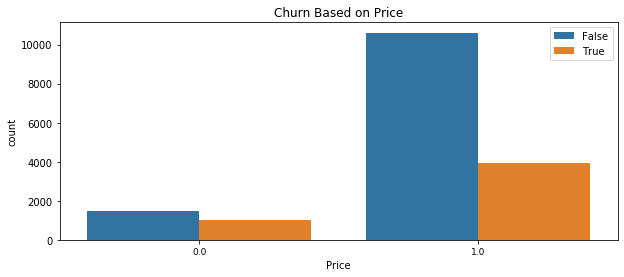

In [127]:
#Churn due to Price
sns.countplot(x='Price', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Price')
plt.savefig('Churn Due to Price.png')

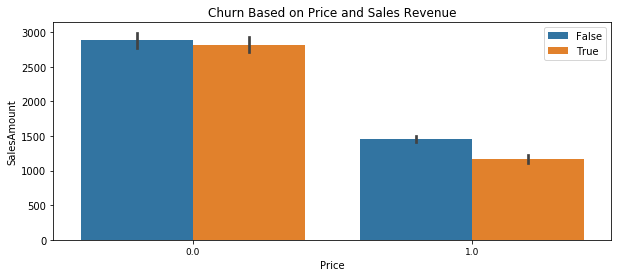

In [128]:
#Churn due to Price and Sales Revenue
sns.barplot(x='Price',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Price and Sales Revenue')
plt.savefig('Churn Due to Price and Revenue.png')

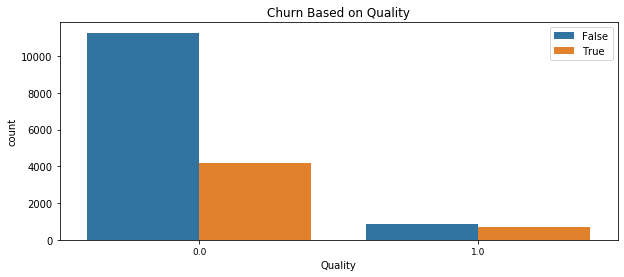

In [129]:
#Churn due to Quality
sns.countplot(x='Quality', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Quality')
plt.savefig('Churn Due to Quality.png')

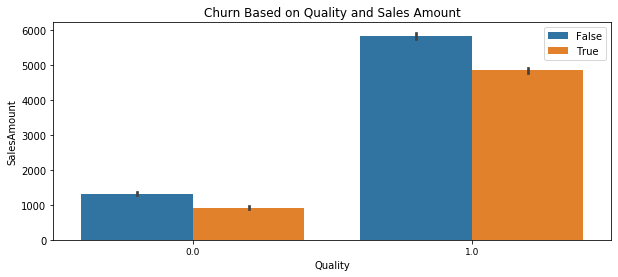

In [130]:
#Churn due to Quality
sns.barplot(x='Quality',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Quality and Sales Amount')
plt.savefig('Churn Due to Quality and Sales Amount.png')

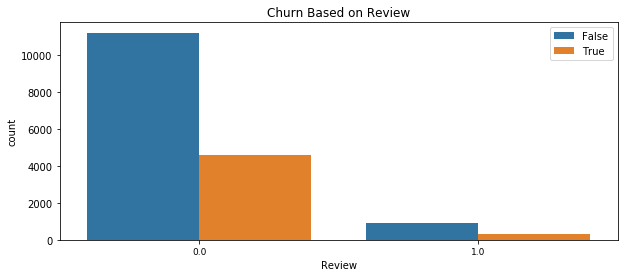

In [131]:
#Churn due to Review
sns.countplot(x='Review', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Review')
plt.savefig('Churn Due to Review.png')

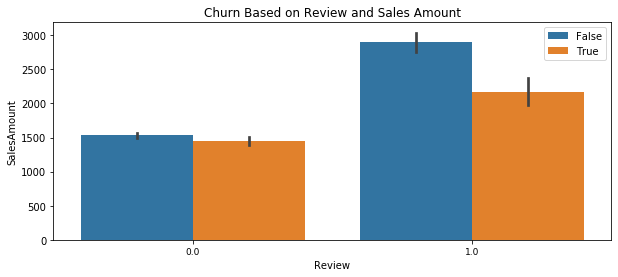

In [132]:
#Churn due to Review and Sales Amount
sns.barplot(x='Review',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Review and Sales Amount')
plt.savefig('Churn Due to Review and Sales Amount.png')

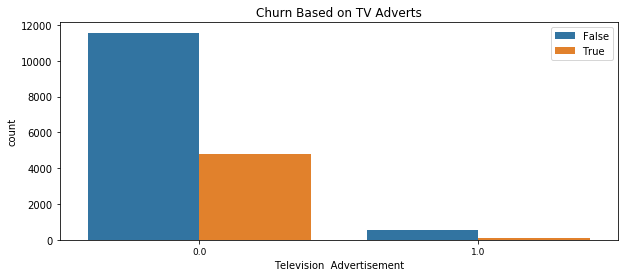

In [133]:
#Churn due to TV Advertisement
sns.countplot(x='Television  Advertisement', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on TV Adverts')
plt.savefig('Churn Due to TV Adverts.png')

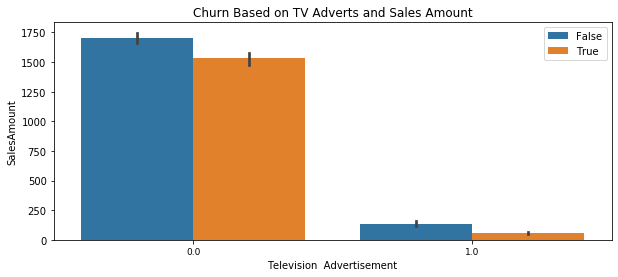

In [134]:
#Churn due to TV Advertisement
sns.barplot(x='Television  Advertisement',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on TV Adverts and Sales Amount')
plt.savefig('Churn Due to TV Adverts and Sales Amount.png')

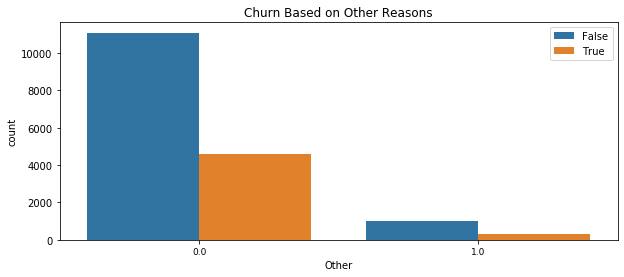

In [135]:
#Churn due to Other
sns.countplot(x='Other', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Other Reasons')
plt.savefig('Churn Due to Others.png')

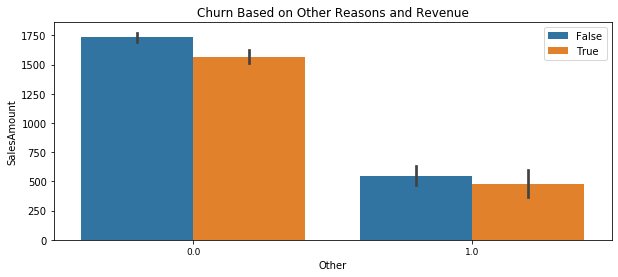

In [136]:
#Churn due to Other
sns.barplot(x='Other',y='SalesAmount', hue='Churned', data =expanded_max)
plt.legend(loc='best')
plt.title('Churn Based on Other Reasons and Revenue')
plt.savefig('Churn Due to Others and Revenue.png')

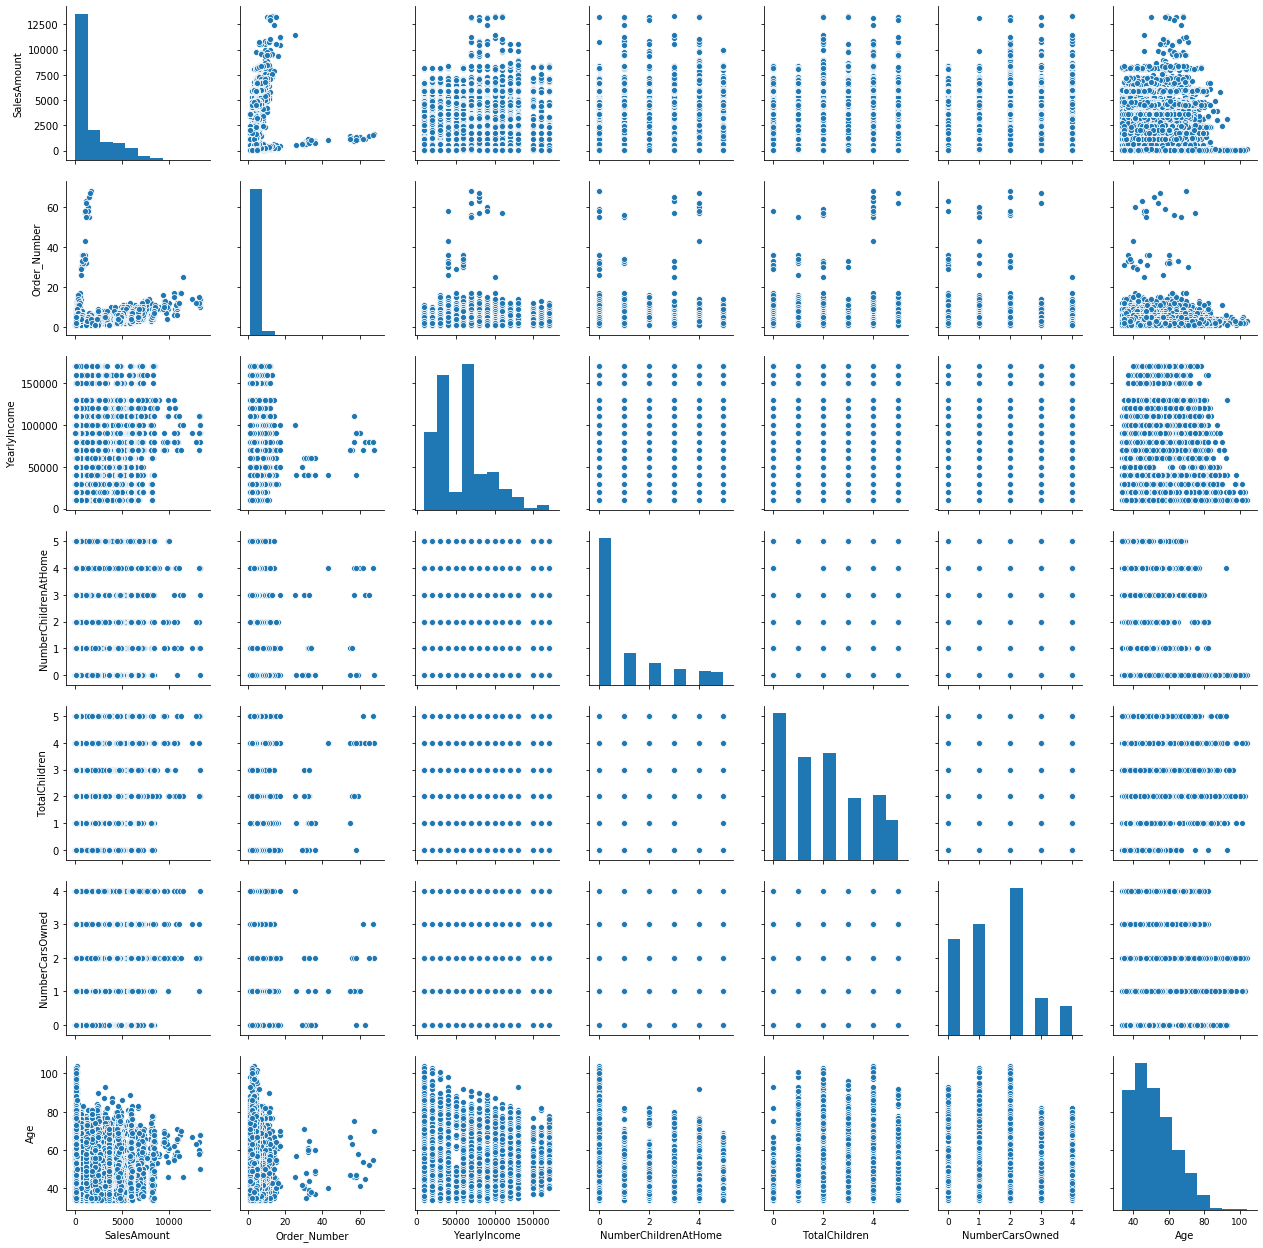

In [137]:
x = expanded_max[['SalesAmount', 'Order_Number','YearlyIncome', 'NumberChildrenAtHome','TotalChildren', 'NumberCarsOwned','Age', 'Continent', 'MaritalStatus' ]]
sns.pairplot(x)
plt.savefig('Manyplots.png')

## Splitting the dataset

In [138]:
#Converting the Churned series to integers

expanded_max['Churned'] = expanded_max.Churned.astype(int)



In [139]:
# First differentiate the churners from non-churners

churners = expanded_max[expanded_max['Churned']==True]
churners

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned
0,11000,8,2013-05-03,8248.9900,8,49,M,M,90000.0,2,...,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,1
46,28217,5,2013-02-25,2408.2900,5,40,F,S,110000.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,1
47,28311,2,2013-01-28,2393.0600,2,48,M,S,100000.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,1
48,28927,2,2013-03-05,2419.0600,2,39,M,S,80000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No Discount,Australia,Pacific,1
49,29115,4,2013-04-13,2407.0400,4,58,F,M,70000.0,2,...,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18470,16668,4,2013-04-21,607.9600,4,40,M,S,30000.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,United States,North America,1
18475,27286,1,2012-11-20,2071.4196,1,44,M,S,60000.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,No Discount,United States,North America,1
18480,17120,2,2013-05-22,1735.9800,2,49,F,S,60000.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,No Discount,United States,North America,1
18481,27421,1,2012-11-05,2049.0982,1,60,F,S,60000.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,No Discount,United States,North America,1


In [140]:
#viewing the records in churners dataset

churners.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5410 entries, 0 to 18482
Data columns (total 28 columns):
Customer_ID                  5410 non-null int64
Order_Number                 5410 non-null int64
OrderDate                    5410 non-null datetime64[ns]
SalesAmount                  5410 non-null float64
OrderQuantity                5410 non-null int64
Age                          5410 non-null int64
Gender                       5410 non-null object
MaritalStatus                5410 non-null object
YearlyIncome                 5410 non-null float64
TotalChildren                5410 non-null int64
NumberChildrenAtHome         5410 non-null int64
Education                    5410 non-null object
Occupation                   5410 non-null object
House_Owner                  5410 non-null object
NumberCarsOwned              5410 non-null int64
CommuteDistance              5410 non-null object
Product_Name                 5410 non-null object
Manufacturer                 4913 non-n

In [141]:
#viewing the non-churners dataset

non_churners = expanded_max[expanded_max['Churned']== False]

non_churners

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned
1,11058,6,2013-06-04,8248.02,6,55,M,M,80000.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0
2,11092,5,2013-06-21,8110.02,5,48,F,M,90000.0,2,...,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,0
3,11095,7,2013-06-25,8158.01,7,52,M,S,70000.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0
4,11107,6,2013-06-21,8171.01,6,44,F,M,90000.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0
5,11447,6,2013-05-31,8078.02,6,40,F,M,70000.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18476,11732,5,2013-08-15,173.47,5,50,M,M,60000.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0
18477,12956,5,2013-10-26,108.46,5,47,M,S,70000.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0
18478,13145,4,2013-11-04,2337.27,4,39,M,M,40000.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0
18479,21249,3,2013-11-26,69.97,3,38,M,S,40000.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0


In [142]:
# The non-churners should be further split to differentiate those that last purchased items 5 months ago.

# Those that last purchased 5 months ago will be included with the non-churners and serve as the training data.

#Getting the max date for the non-churners
non_churners.OrderDate.max()

Timestamp('2014-01-28 00:00:00')

In [143]:
# 3 months from the latest date is October 29 2013

five_month = pd.to_datetime('29-10-2013')
five_month

Timestamp('2013-10-29 00:00:00')

In [144]:
#Splitting the data into those whose last purchase was 5 months ago
#Determine 5 month's churners
churn_five_months = non_churners.OrderDate < five_month
churn_five_months

1         True
2         True
3         True
4         True
5         True
         ...  
18476     True
18477     True
18478    False
18479    False
18483    False
Name: OrderDate, Length: 13074, dtype: bool

In [145]:
# Adding the churn_five_months into the non_churners dataset in the variable 'Churned_five'

non_churners['Churned_five']= churn_five_months

#Reviewing the dataset
non_churners.head()

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned,Churned_five
1,11058,6,2013-06-04,8248.02,6,55,M,M,80000.0,2,...,0.0,0.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True
2,11092,5,2013-06-21,8110.02,5,48,F,M,90000.0,2,...,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,0,True
3,11095,7,2013-06-25,8158.01,7,52,M,S,70000.0,1,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True
4,11107,6,2013-06-21,8171.01,6,44,F,M,90000.0,1,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True
5,11447,6,2013-05-31,8078.02,6,40,F,M,70000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True


In [146]:
#Seperating the five month churners from non-churners

split_churn = non_churners[non_churners['Churned_five']==True]

split_churn


,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned,Churned_five
1,11058,6,2013-06-04,8248.02,6,55,M,M,80000.0,2,...,0.0,0.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True
2,11092,5,2013-06-21,8110.02,5,48,F,M,90000.0,2,...,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,0,True
3,11095,7,2013-06-25,8158.01,7,52,M,S,70000.0,1,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True
4,11107,6,2013-06-21,8171.01,6,44,F,M,90000.0,1,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True
5,11447,6,2013-05-31,8078.02,6,40,F,M,70000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18463,24442,2,2013-08-25,82.59,2,63,F,M,40000.0,3,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,True
18471,27503,1,2013-08-03,21.49,1,39,M,S,40000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,True
18474,18315,2,2013-06-27,7.28,2,35,F,M,30000.0,0,...,0.0,1.0,0.0,0.0,0.0,Volume Discount,United States,North America,0,True
18476,11732,5,2013-08-15,173.47,5,50,M,M,60000.0,1,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,True


In [147]:
#The non-churners (those that bought last in the 3 months) will be the test group and holdout sample for testing our mode
test_group= non_churners[non_churners['Churned_five']==False]

test_group

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned,Churned_five
13,11901,7,2013-11-09,8248.0100,7,47,F,S,60000.0,2,...,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,0,False
34,13113,7,2013-11-04,6832.4096,7,48,M,S,100000.0,0,...,0.0,1.0,0.0,1.0,0.0,Volume Discount,Australia,Pacific,0,False
35,13126,7,2013-11-23,6815.0782,7,51,F,S,70000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,False
36,13618,4,2013-11-28,6763.1482,4,38,M,S,70000.0,0,...,0.0,0.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,False
37,13620,7,2013-11-13,6848.0682,7,39,M,S,70000.0,0,...,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18472,27657,4,2013-11-28,84.9600,4,78,M,M,50000.0,2,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False
18473,22124,2,2013-11-12,34.9800,2,77,F,M,60000.0,3,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False
18478,13145,4,2013-11-04,2337.2700,4,39,M,M,40000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False
18479,21249,3,2013-11-26,69.9700,3,38,M,S,40000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False


In [148]:
holdout_sample = non_churners[non_churners['Churned_five']==False]

In [149]:
holdout_sample

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned,Churned_five
13,11901,7,2013-11-09,8248.0100,7,47,F,S,60000.0,2,...,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,0,False
34,13113,7,2013-11-04,6832.4096,7,48,M,S,100000.0,0,...,0.0,1.0,0.0,1.0,0.0,Volume Discount,Australia,Pacific,0,False
35,13126,7,2013-11-23,6815.0782,7,51,F,S,70000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,False
36,13618,4,2013-11-28,6763.1482,4,38,M,S,70000.0,0,...,0.0,0.0,0.0,0.0,0.0,No Discount,Australia,Pacific,0,False
37,13620,7,2013-11-13,6848.0682,7,39,M,S,70000.0,0,...,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18472,27657,4,2013-11-28,84.9600,4,78,M,M,50000.0,2,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False
18473,22124,2,2013-11-12,34.9800,2,77,F,M,60000.0,3,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False
18478,13145,4,2013-11-04,2337.2700,4,39,M,M,40000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False
18479,21249,3,2013-11-26,69.9700,3,38,M,S,40000.0,0,...,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0,False


In [150]:
#Join the split_churn and churners tables
#viewing the shapes of both dataset to ensure they are the same

churners.shape, split_churn.shape

((5410, 28), (8058, 29))

In [151]:
#Check their datatypes
churners.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5410 entries, 0 to 18482
Data columns (total 28 columns):
Customer_ID                  5410 non-null int64
Order_Number                 5410 non-null int64
OrderDate                    5410 non-null datetime64[ns]
SalesAmount                  5410 non-null float64
OrderQuantity                5410 non-null int64
Age                          5410 non-null int64
Gender                       5410 non-null object
MaritalStatus                5410 non-null object
YearlyIncome                 5410 non-null float64
TotalChildren                5410 non-null int64
NumberChildrenAtHome         5410 non-null int64
Education                    5410 non-null object
Occupation                   5410 non-null object
House_Owner                  5410 non-null object
NumberCarsOwned              5410 non-null int64
CommuteDistance              5410 non-null object
Product_Name                 5410 non-null object
Manufacturer                 4913 non-n

In [152]:
split_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8058 entries, 1 to 18477
Data columns (total 29 columns):
Customer_ID                  8058 non-null int64
Order_Number                 8058 non-null int64
OrderDate                    8058 non-null datetime64[ns]
SalesAmount                  8058 non-null float64
OrderQuantity                8058 non-null int64
Age                          8058 non-null int64
Gender                       8058 non-null object
MaritalStatus                8058 non-null object
YearlyIncome                 8058 non-null float64
TotalChildren                8058 non-null int64
NumberChildrenAtHome         8058 non-null int64
Education                    8058 non-null object
Occupation                   8058 non-null object
House_Owner                  8058 non-null object
NumberCarsOwned              8058 non-null int64
CommuteDistance              8058 non-null object
Product_Name                 8058 non-null object
Manufacturer                 7444 non-n

In [153]:
#drop the Churned_five column in the split_churn dataset
split_churn.drop(['Churned_five'], axis=1, inplace = True)


In [154]:
#concatenate both datasets to create a new variable, train

train= pd.concat([churners,split_churn])

train

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned
0,11000,8,2013-05-03,8248.99,8,49,M,M,90000.0,2,...,1.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,Australia,Pacific,1
46,28217,5,2013-02-25,2408.29,5,40,F,S,110000.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,1
47,28311,2,2013-01-28,2393.06,2,48,M,S,100000.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,1
48,28927,2,2013-03-05,2419.06,2,39,M,S,80000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No Discount,Australia,Pacific,1
49,29115,4,2013-04-13,2407.04,4,58,F,M,70000.0,2,...,1.0,0.0,1.0,0.0,0.0,0.0,No Discount,Australia,Pacific,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18463,24442,2,2013-08-25,82.59,2,63,F,M,40000.0,3,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0
18471,27503,1,2013-08-03,21.49,1,39,M,S,40000.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0
18474,18315,2,2013-06-27,7.28,2,35,F,M,30000.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,Volume Discount,United States,North America,0
18476,11732,5,2013-08-15,173.47,5,50,M,M,60000.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,No Discount,United States,North America,0


In [155]:
#save the file to excel
train.to_excel('train_data.xlsx')

## Preparing the data for churn Prediction

In [156]:
#Dropping the customer_id
train.drop(['Customer_ID'], axis =1, inplace = True)

In [157]:
#confirming if there're empty values in the dataset
train.isnull().sum()

Order_Number                    0
OrderDate                       0
SalesAmount                     0
OrderQuantity                   0
Age                             0
Gender                          0
MaritalStatus                   0
YearlyIncome                    0
TotalChildren                   0
NumberChildrenAtHome            0
Education                       0
Occupation                      0
House_Owner                     0
NumberCarsOwned                 0
CommuteDistance                 0
Product_Name                    0
Manufacturer                 1111
On Promotion                 1111
Other                        1111
Price                        1111
Quality                      1111
Review                       1111
Television  Advertisement    1111
EnglishPromotionType            0
Country                         0
Continent                       0
Churned                         0
dtype: int64

In [158]:
#Dropping records with empty values in the null columns
#train.dropna(subset=['Manufacturer', 'On Promotion', 'Other', 'Price', 'Quality', 'Review', 'Television  Advertisement'], how='any', inplace=True )

In [159]:
#filling the null values with the mode
train = train.fillna(train.mode().iloc[0])

In [160]:
#View the dataset again to confirm if null values are still there
train.isnull().sum()

Order_Number                 0
OrderDate                    0
SalesAmount                  0
OrderQuantity                0
Age                          0
Gender                       0
MaritalStatus                0
YearlyIncome                 0
TotalChildren                0
NumberChildrenAtHome         0
Education                    0
Occupation                   0
House_Owner                  0
NumberCarsOwned              0
CommuteDistance              0
Product_Name                 0
Manufacturer                 0
On Promotion                 0
Other                        0
Price                        0
Quality                      0
Review                       0
Television  Advertisement    0
EnglishPromotionType         0
Country                      0
Continent                    0
Churned                      0
dtype: int64

In [161]:
# Next we convert the data to numerical values
#Checking out the exisiting data types in the dataset
train.dtypes

Order_Number                          int64
OrderDate                    datetime64[ns]
SalesAmount                         float64
OrderQuantity                         int64
Age                                   int64
Gender                               object
MaritalStatus                        object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome                  int64
Education                            object
Occupation                           object
House_Owner                          object
NumberCarsOwned                       int64
CommuteDistance                      object
Product_Name                         object
Manufacturer                        float64
On Promotion                        float64
Other                               float64
Price                               float64
Quality                             float64
Review                              float64
Television  Advertisement       

In [162]:
#Changing the data from object to numeric
train['Gender'] = pd.to_numeric(train.Gender, errors='coerce', downcast='float')
train['MaritalStatus'] = pd.to_numeric(train.MaritalStatus, errors='coerce', downcast='float')
train['Education'] = pd.to_numeric(train.Education, errors='coerce', downcast='float')
train['Occupation'] = pd.to_numeric(train.Occupation, errors='coerce', downcast='float')
train['House_Owner'] = pd.to_numeric(train.House_Owner, errors='coerce', downcast='float')
train['CommuteDistance'] = pd.to_numeric(train.CommuteDistance, errors='coerce', downcast='float')
train['EnglishPromotionType'] = pd.to_numeric(train.EnglishPromotionType, errors='coerce', downcast='float')
train['Country'] = pd.to_numeric(train.Country, errors='coerce', downcast='float')
train['Continent'] = pd.to_numeric(train.Continent, errors='coerce', downcast='float')
train['OrderDate'] = pd.to_numeric(train.OrderDate, errors='coerce', downcast='float')
train['YearlyIncome'] = pd.to_numeric(train.MaritalStatus, errors='coerce', downcast='integer')

train.dtypes

Order_Number                   int64
OrderDate                    float32
SalesAmount                  float64
OrderQuantity                  int64
Age                            int64
Gender                       float32
MaritalStatus                float32
YearlyIncome                 float32
TotalChildren                  int64
NumberChildrenAtHome           int64
Education                    float32
Occupation                   float32
House_Owner                  float32
NumberCarsOwned                int64
CommuteDistance              float32
Product_Name                  object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
EnglishPromotionType         float32
Country                      float32
Continent                    float32
Churned                        int32
d

In [163]:
#Further transforming the dataset to numeric
for column in train.columns:
    if train[column].dtype ==np.number:
        continue
    train[column] = LabelEncoder().fit_transform(train[column])
    
train.dtypes

Order_Number                   int64
OrderDate                      int64
SalesAmount                  float64
OrderQuantity                  int64
Age                            int64
Gender                         int64
MaritalStatus                  int64
YearlyIncome                   int64
TotalChildren                  int64
NumberChildrenAtHome           int64
Education                      int64
Occupation                     int64
House_Owner                    int64
NumberCarsOwned                int64
CommuteDistance                int64
Product_Name                   int32
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
EnglishPromotionType           int64
Country                        int64
Continent                      int64
Churned                        int64
d

In [164]:
#Getting the first 5 rows of the dataset
train.head(3)

,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,NumberChildrenAtHome,...,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned
0,7,461,8248.99,7,15,0,0,0,2,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1
46,4,394,2408.29,4,6,8970,8970,8970,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,8970,8970,8970,1
47,1,366,2393.06,1,14,8971,8971,8971,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,8971,8971,8971,1


In [165]:
#Confirming columns in the dataset

train.columns

Index(['Order_Number', 'OrderDate', 'SalesAmount', 'OrderQuantity', 'Age',
       'Gender', 'MaritalStatus', 'YearlyIncome', 'TotalChildren',
       'NumberChildrenAtHome', 'Education', 'Occupation', 'House_Owner',
       'NumberCarsOwned', 'CommuteDistance', 'Product_Name', 'Manufacturer',
       'On Promotion', 'Other', 'Price', 'Quality', 'Review',
       'Television  Advertisement', 'EnglishPromotionType', 'Country',
       'Continent', 'Churned'],
      dtype='object')

## Finding the Correlation Between Stated Variables

In [166]:
print(train.corr())

train.corr().to_excel('Correlation.xlsx')

                           Order_Number  OrderDate  SalesAmount  \
Order_Number                   1.000000   0.248634     0.460304   
OrderDate                      0.248634   1.000000    -0.041815   
SalesAmount                    0.460304  -0.041815     1.000000   
OrderQuantity                  1.000000   0.248634     0.460304   
Age                           -0.010954   0.009961    -0.071398   
Gender                        -0.085152  -0.523576     0.030847   
MaritalStatus                 -0.085152  -0.523576     0.030847   
YearlyIncome                  -0.085152  -0.523576     0.030847   
TotalChildren                 -0.007658   0.018844    -0.074112   
NumberChildrenAtHome           0.074902   0.064071     0.008914   
Education                     -0.085152  -0.523576     0.030847   
Occupation                    -0.085152  -0.523576     0.030847   
House_Owner                    0.041084   0.034374     0.030410   
NumberCarsOwned                0.025937   0.054722    -0.04966

# Using vote based approach to get the best features

In [167]:
# https://medium.com/analytics-vidhya/feature-selection-by-using-voting-approach-e0d1c7182a21

# To find the best features
xtrain = train.drop(['Churned', 'OrderDate'], axis = 1)
ytrain = train.Churned


In [168]:
from xverse.ensemble import VotingSelector
clf = VotingSelector(minimum_votes=3)

In [169]:
clf.fit(xtrain,ytrain)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=3, no_of_features=12,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [170]:
clf.feature_importances_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One
0,Occupation,5.049791,0.079912,0.000000,0.090276,985.956471,2.719710e-05
1,EnglishPromotionType,5.049791,0.246398,0.000000,0.170047,985.956471,3.682711e-05
2,CommuteDistance,5.049791,0.007365,0.000000,0.124814,985.956471,4.699498e-05
3,MaritalStatus,5.049791,0.026483,0.000000,0.140451,985.956471,1.411087e-05
4,Gender,5.049791,0.163193,0.000000,0.067470,985.956471,-1.937668e-07
5,YearlyIncome,5.049791,0.100641,0.000000,0.024703,985.956471,3.195355e-05
6,Education,5.049791,0.129284,0.000000,0.093525,985.956471,2.021895e-05
7,Continent,5.049791,0.107618,0.000000,0.149953,985.956471,1.011663e-05
8,Country,5.049791,0.118651,0.000000,0.096808,985.956471,9.982873e-06
9,OrderQuantity,0.088917,0.005704,-0.127862,0.004219,40.409385,-8.684688e-02


In [171]:
#Observing the votes from this feature selection purpose
clf.feature_votes_
clf.feature_votes_.to_excel('votes.xlsx')

In [172]:
# transform the data into important features
xctrain =clf.transform(xtrain)
xctrain

,Order_Number,OrderQuantity,Occupation,Continent,EnglishPromotionType,Quality,Country,Education,YearlyIncome,Gender,MaritalStatus,CommuteDistance
0,7,7,0,0,0,-0.073344,0,0,0,0,0,0
46,4,4,8970,8970,8970,-0.073344,8970,8970,8970,8970,8970,8970
47,1,1,8971,8971,8971,-0.073344,8971,8971,8971,8971,8971,8971
48,1,1,8972,8972,8972,-0.073344,8972,8972,8972,8972,8972,8972
49,3,3,8973,8973,8973,-0.073344,8973,8973,8973,8973,8973,8973
...,...,...,...,...,...,...,...,...,...,...,...,...
18463,1,1,4490,4490,4490,-0.073344,4490,4490,4490,4490,4490,4490
18471,0,0,4491,4491,4491,-0.073344,4491,4491,4491,4491,4491,4491
18474,1,1,4492,4492,4492,-0.073344,4492,4492,4492,4492,4492,4492
18476,4,4,11783,11783,11783,-0.073344,11783,11783,11783,11783,11783,11783


## Grid Search for Parameter Selection

In [173]:
# https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
xtrain_train, xtrain_test, ytrain_train, ytrain_test = train_test_split(xtrain,ytrain, random_state = 42)

In [174]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
clf = DummyClassifier (strategy = 'most_frequent').fit(xtrain_train, ytrain_train)
y_pred = clf.predict(xtrain_test)

In [175]:
#Distribution of y test
print('y actual : \n' + str(ytrain_test.value_counts()))

# Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))

y actual : 
0    1994
1    1373
Name: Churned, dtype: int64
y predicted : 
0    3367
dtype: int64


In [176]:
#This shows that 1994 customers did not churn while 1373 customers churned.
# The predictions showed all the customers did not churn because it is the dominant class.

# Model Evaluation

In [177]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(ytrain_test,y_pred)))
print('Precision Score : ' + str(precision_score(ytrain_test,y_pred)))
print('Recall Score : ' + str(recall_score(ytrain_test,y_pred)))
print('F1 Score : ' + str(f1_score(ytrain_test,y_pred)))

Accuracy Score : 0.5922185922185922
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0


In [178]:
#Dummy Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(ytrain_test,y_pred)))

Confusion Matrix : 
[[1994    0]
 [1373    0]]


In [179]:
# True Positives = 0 and True Negatives = 1994

In [180]:
#Now we have the accuracy, we try to build the logistic regression model
#with default parameters and evaluate the model

#logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(xtrain_train,ytrain_train)
y_pred = clf.predict(xtrain_test)

In [181]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(ytrain_test,y_pred)))
print('Precision Score : ' + str(precision_score(ytrain_test,y_pred)))
print('Recall Score : ' + str(recall_score(ytrain_test,y_pred)))
print('F1 Score : ' + str(f1_score(ytrain_test,y_pred)))

Accuracy Score : 0.8443718443718444
Precision Score : 0.8213474640423921
Recall Score : 0.7902403495994174
F1 Score : 0.8054936896807721


In [182]:
#Logistic Regression Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(ytrain_test,y_pred)))

Confusion Matrix : 
[[1758  236]
 [ 288 1085]]


In [183]:
#The accuracy has improved to 83% But the false negatives and false positives are high affecting
# the ability to address concerns raised.

# Grid Search will maximize recall and reduce the false positives and negatives

In [184]:
#Grid Search
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(xtrain_train, ytrain_train)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [185]:
#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(xtrain_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(ytrain_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(ytrain_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(ytrain_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(ytrain_test,y_pred_acc)))


Accuracy Score : 0.8437778437778438
Precision Score : 0.8215641609719059
Recall Score : 0.7880553532410779
F1 Score : 0.8044609665427509


In [186]:
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(ytrain_test,y_pred_acc)

array([[1759,  235],
       [ 291, 1082]], dtype=int64)

## Logistic Regression

In [187]:
#Scale the data
x_l= xtrain
y_l= ytrain

sc=StandardScaler().fit_transform(x_l)

In [188]:
#Split the train data into 60% train and 40% testing

x_l_train, x_l_test, y_l_train, y_l_test = train_test_split(x_l,y_l,test_size = 0.4, random_state = 42)

print(x_l_train.shape, y_l_train.shape)
print(x_l_test.shape, y_l_test.shape)

(8080, 25) (8080,)
(5388, 25) (5388,)


In [189]:
#Create the model

model_l = LogisticRegression()

#Train the model
model_l.fit(x_l_train,y_l_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [190]:
#Create predictions on test data
predictions = model_l.predict(x_l_test)
train_pred= model_l.predict(x_l_train)
# print predictions

print(predictions)

[0 0 0 ... 1 0 1]


Text(0, 0.5, 'Predictions')

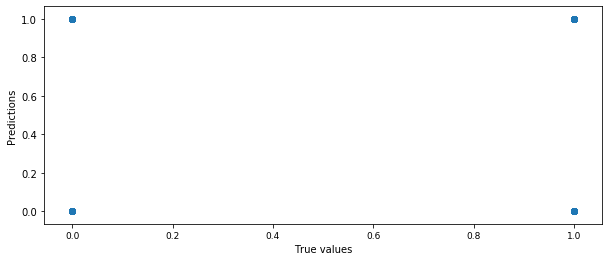

In [191]:
#Plotting the predictions
plt.scatter(y_l_test, predictions)
plt.xlabel('True values')
plt.ylabel('Predictions')

In [192]:
#Printing the accuracy score
print( "Score:", model_l.score(x_l_test,y_l_test))

Score: 0.816815144766147


In [193]:
#Check the precision, recall and F1- Score

print(classification_report(y_l_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3218
           1       0.78      0.76      0.77      2170

    accuracy                           0.82      5388
   macro avg       0.81      0.81      0.81      5388
weighted avg       0.82      0.82      0.82      5388



In [194]:
prediction_test = model_l.predict(x_l_test)



In [195]:
#Print the prediction accuracy
print(metrics.accuracy_score(y_l_test, prediction_test))

0.816815144766147


In [196]:
# Confusion matrix to confirm the predictions
from sklearn.metrics import confusion_matrix
confusion_matrix(y_l_test,predictions)

array([[2755,  463],
       [ 524, 1646]], dtype=int64)

In [197]:
#Our prediction gave 2,698 true negatives and 1,652 True positives.

In [198]:
# To see which attribute most affected churn
#Set coefficient of model to zero and look at the weight of each variable

#Getting the weight of each variable

weight = pd.Series(model_l.coef_[0], index=x_l.columns.values)
weight.sort_values(ascending = False)

Quality                      0.362877
Manufacturer                 0.252935
TotalChildren                0.018311
EnglishPromotionType         0.000055
Gender                       0.000055
YearlyIncome                 0.000055
CommuteDistance              0.000055
Country                      0.000055
MaritalStatus                0.000055
Occupation                   0.000055
Education                    0.000055
Continent                    0.000055
SalesAmount                 -0.000138
Age                         -0.003014
Product_Name                -0.004776
NumberChildrenAtHome        -0.015327
Other                       -0.109007
OrderQuantity               -0.138101
Order_Number                -0.138101
On Promotion                -0.192370
Review                      -0.259477
NumberCarsOwned             -0.355781
Television  Advertisement   -0.430213
House_Owner                 -0.486335
Price                       -0.718415
dtype: float64

In [199]:
# The positive numbers have a higher possibility of churn while the negative numbers are negatively correlated to churning.

# Cross Validation Using Logistic Regression

In [200]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression()

In [201]:
from sklearn.model_selection import KFold


In [202]:
all_accuracies =KFold() 

In [203]:
# KFold = (clf, X = x_l_train, y=y_l_train, cv=10)

In [204]:
print (all_accuracies)

KFold(n_splits=3, random_state=None, shuffle=False)


In [205]:
#find the average of all accuracies
#print(all_accuracies.mean())

In [206]:
#Find the standard deviation of all accuracies to get an
# understanding of the variance

# print(all_accuracies.std())

In [207]:
#The variation is 1.2% which is the percentage of variance
#on validation tests performed. Our model is not overfitted
# and will perform well on the data for scoring.

## Cross Validation

In [208]:
#https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6?source=search_post---------0
##https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
classifier = RandomForestClassifier(n_estimators = 300, random_state = 42)
all_accuracies = cross_val_score(classifier,xtrain_train,ytrain_train, cv=10 )

print(all_accuracies)

[1.         0.99901088 0.99802176 1.         0.9970297  1.
 1.         0.99900892 0.99900892 0.99900892]


In [209]:
#Find the average of all accuracies
print(all_accuracies.mean())

0.9991089103087344


In [210]:
#find the Stdev of all_accuracies
print(all_accuracies.std())

0.0009338503711239194


## Random Forest Classification

In [211]:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d  
# https://www.kaggle.com/codeastar/using-random-forest-to-find-feature-importance
# https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# split data into train and test portions
xtrain_train, xtrain_test, ytrain_train, ytrain_test = train_test_split(xtrain,ytrain, test_size=0.4)

#Load our model and fitting it
model_r=RandomForestClassifier()
model_r.fit(xtrain_train,ytrain_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [212]:
# Testing the model
y_pred = model_r.predict(xtrain_test)
y_pred

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

Text(0, 0.5, 'Predictions')

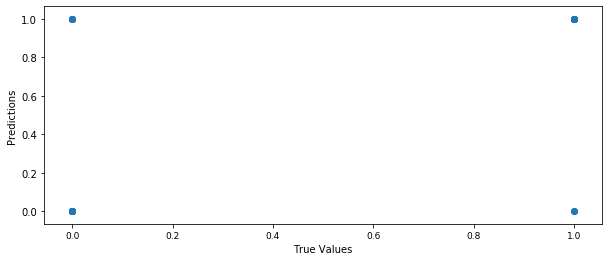

In [213]:
# visualizing the model
plt.scatter(ytrain_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [214]:
#Printing the accuracy score
print('Score: ', model_r.score(xtrain_test, ytrain_test))

Score:  0.9988864142538976


In [215]:
# Using AUC (Area under curve as an evaluation metric) to get the target, which should be binary
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(ytrain_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9989179048167812

In [216]:
# Selecting our train dataset
print(xtrain_train.head(4))
print(xtrain.columns)

       Order_Number  SalesAmount  OrderQuantity  Age  Gender  MaritalStatus  \
3375              0         4.99              0    9    2426           2426   
6340              1      1735.98              1   11    2768           2768   
17694             1        78.98              1   27    4221           4221   
13348             1        30.48              1   19    6044           6044   

       YearlyIncome  TotalChildren  NumberChildrenAtHome  Education  ...  \
3375           2426              0                     0       2426  ...   
6340           2768              0                     0       2768  ...   
17694          4221              3                     0       4221  ...   
13348          6044              1                     3       6044  ...   

       Manufacturer  On Promotion  Other  Price  Quality  Review  \
3375            0.0           0.0    0.0    1.0      0.0     0.0   
6340            0.0           0.0    0.0    0.0      0.0     1.0   
17694           0.0

In [217]:
#Scale the data
x_r= xtrain_train
y_r= ytrain_train

In [218]:
#Getting the feature importance
model_r.fit(x_r,y_r)
#Display the relative importance of each attribute
importances = model_r.feature_importances_
importances

array([1.03058384e-02, 9.60375591e-04, 3.31033358e-03, 4.53258958e-04,
       7.13896775e-02, 9.71059864e-02, 7.59981773e-02, 0.00000000e+00,
       1.43258601e-03, 1.63738150e-02, 1.41738507e-01, 8.54777294e-05,
       1.13258253e-04, 2.43438937e-01, 5.26153327e-03, 0.00000000e+00,
       4.31486143e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.10246567e-02, 1.76776333e-01,
       1.03799762e-01])

In [219]:
#Sort it

print("Sorted Feature Importance: ")
sorted_feature_importance = sorted(zip(importances, list(x_r)), reverse = True)
print(sorted_feature_importance)

Sorted Feature Importance: 
[(0.2434389371589339, 'CommuteDistance'), (0.17677633329508907, 'Country'), (0.1417385071717082, 'Occupation'), (0.10379976150775647, 'Continent'), (0.09710598638516668, 'MaritalStatus'), (0.075998177290419, 'YearlyIncome'), (0.07138967754512712, 'Gender'), (0.051024656718543074, 'EnglishPromotionType'), (0.0163738150382968, 'Education'), (0.010305838358093535, 'Order_Number'), (0.005261533266704121, 'Product_Name'), (0.003310333584149143, 'OrderQuantity'), (0.0014325860059345853, 'NumberChildrenAtHome'), (0.0009603755907573456, 'SalesAmount'), (0.0004532589584603456, 'Age'), (0.0004314861426889421, 'On Promotion'), (0.00011325825274877074, 'NumberCarsOwned'), (8.547772942291338e-05, 'House_Owner'), (0.0, 'TotalChildren'), (0.0, 'Television  Advertisement'), (0.0, 'Review'), (0.0, 'Quality'), (0.0, 'Price'), (0.0, 'Other'), (0.0, 'Manufacturer')]


In [220]:
# Education, Marital Status, Country and Yearly Income are the most important variables in the dataset
#Checking the accuracy of the model
#Dividing the data into train and test split

xtrain_train, xtrain_test, ytrain_train, ytrain_test = train_test_split(xtrain,ytrain, test_size= 0.4, random_state =42)


In [221]:
#Feature scaling
sc_r= StandardScaler()
x_r_train = sc_r.fit_transform(xtrain_train)
x_r_test = sc_r.transform(xtrain_test)

In [222]:
#training the algorithm
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier (n_estimators=100, random_state = 42)
classifier.fit(xtrain_train, ytrain_train)
y_pred = classifier.predict(x_r_test)

In [223]:
#Finding accuracy, recall, precision f1-score et all,

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(ytrain_test,y_pred))
print(classification_report(ytrain_test,y_pred))
print(accuracy_score(ytrain_test,y_pred))

[[3218    0]
 [2170    0]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3218
           1       0.00      0.00      0.00      2170

    accuracy                           0.60      5388
   macro avg       0.30      0.50      0.37      5388
weighted avg       0.36      0.60      0.45      5388

0.597253155159614


## Finding the Most Determinant Variables

In [224]:
model_r.fit(x_r,y_r)

preds = model_r.predict(x_r)

from sklearn.metrics import accuracy_score
accuracy_r = accuracy_score(preds,y_r)
print(accuracy_r)

0.9998762376237624


In [225]:
from pandas import DataFrame

series_r = DataFrame(model_r.feature_importances_, columns = ['RF'], index = x_r.columns)


In [226]:
series_r = series_r.reset_index()
series_r.sort_values(['RF'], ascending =0)

,index,RF
10,Occupation,0.209162
6,YearlyIncome,0.182848
24,Continent,0.176464
23,Country,0.134419
5,MaritalStatus,0.111138
9,Education,0.080342
13,CommuteDistance,0.033839
22,EnglishPromotionType,0.026016
4,Gender,0.025140
0,Order_Number,0.010523


In [227]:
# The 4 most determinant variables were Marital Status, Commute Distance, Country, Promotion and Education in that order.

## Chi Square

In [228]:
#Importing the libraies and fitting the model

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model= SelectKBest(score_func=chi2, k=5)

fit = model.fit(x_l.abs(),y_l)

In [229]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_,columns =['Chi_Square'], index=xtrain.columns)

In [230]:
#Resetting the index
chi_sq = chi_sq.reset_index()

In [231]:
#printing the values
chi_sq.sort_values('Chi_Square', ascending = 0)

,index,Chi_Square
24,Continent,13277875.79
10,Occupation,13277875.79
23,Country,13277875.79
22,EnglishPromotionType,13277875.79
4,Gender,13277875.79
5,MaritalStatus,13277875.79
6,YearlyIncome,13277875.79
13,CommuteDistance,13277875.79
9,Education,13277875.79
1,SalesAmount,78879.72


In [232]:
# The important variables were Continet, Occupation, Country, Promotion type and Gender.

## Variable Importance Using Extra Trees Classifier 

In [233]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier ()
model.fit(xtrain, ytrain)

print(model.feature_importances_)

[0.012637   0.00766582 0.00596033 0.00046804 0.05159195 0.08397111
 0.06612803 0.00047978 0.00120901 0.11648723 0.06683022 0.00039749
 0.00130667 0.14199006 0.00436562 0.00165261 0.00350831 0.00063866
 0.00083944 0.0022035  0.00047342 0.00021962 0.18669867 0.09779906
 0.14447836]


In [234]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ['Extratrees'], index = xtrain.columns)

In [235]:
FI = FI.reset_index()

In [236]:
FI.sort_values(['Extratrees'], ascending = 0)

,index,Extratrees
22,EnglishPromotionType,0.19
24,Continent,0.14
13,CommuteDistance,0.14
9,Education,0.12
23,Country,0.10
5,MaritalStatus,0.08
10,Occupation,0.07
6,YearlyIncome,0.07
4,Gender,0.05
0,Order_Number,0.01


In [237]:
#The important variables are Education, Continent, Commnute Distance, Occupation and Marital Status

## Save model for future use

In [238]:
import pandas
from sklearn.externals import joblib

filename= 'Churn_Model.model'

i= [xtrain,model_l] #using logistic regression

joblib.dump(i,filename)

['Churn_Model.model']

In [239]:
#Checking the number of null values in the test dataset
test_group.isnull().sum()

Customer_ID                    0
Order_Number                   0
OrderDate                      0
SalesAmount                    0
OrderQuantity                  0
Age                            0
Gender                         0
MaritalStatus                  0
YearlyIncome                   0
TotalChildren                  0
NumberChildrenAtHome           0
Education                      0
Occupation                     0
House_Owner                    0
NumberCarsOwned                0
CommuteDistance                0
Product_Name                   0
Manufacturer                 351
On Promotion                 351
Other                        351
Price                        351
Quality                      351
Review                       351
Television  Advertisement    351
EnglishPromotionType           0
Country                        0
Continent                      0
Churned                        0
Churned_five                   0
dtype: int64

## Score the New Data

In [240]:
# The hold out sample is the test_group

# Checking the data types in the test group

test_group.dtypes

Customer_ID                           int64
Order_Number                          int64
OrderDate                    datetime64[ns]
SalesAmount                         float64
OrderQuantity                         int64
Age                                   int64
Gender                               object
MaritalStatus                        object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome                  int64
Education                            object
Occupation                           object
House_Owner                          object
NumberCarsOwned                       int64
CommuteDistance                      object
Product_Name                         object
Manufacturer                        float64
On Promotion                        float64
Other                               float64
Price                               float64
Quality                             float64
Review                          

In [241]:
#dropping the columns with churn values, Order_date and customer ID

test_group.drop(['Churned_five', 'OrderDate', 'Churned', 'Customer_ID'], axis=1, inplace= True)

In [242]:
#Reconfirming that all irrelievant columns have dropped
test_group.dtypes

Order_Number                   int64
SalesAmount                  float64
OrderQuantity                  int64
Age                            int64
Gender                        object
MaritalStatus                 object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
Education                     object
Occupation                    object
House_Owner                   object
NumberCarsOwned                int64
CommuteDistance               object
Product_Name                  object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
EnglishPromotionType          object
Country                       object
Continent                     object
dtype: object

In [243]:
#Converting all data types to numerical data types
for column in test_group.columns:
    if test_group[column].dtype ==np.number:
        continue
    test_group[column] = LabelEncoder().fit_transform(test_group[column])
    
test_group.dtypes

#test_group['Gender'] = pd.to_numeric(test_group.Gender, errors='coerce', downcast='integer')
#test_group['MaritalStatus'] = pd.to_numeric(test_group.MaritalStatus, errors='coerce', downcast='integer')
#test_group['Education'] = pd.to_numeric(test_group.Education, errors='coerce', downcast='integer')
#test_group['Occupation'] = pd.to_numeric(test_group.Occupation, errors='coerce', downcast='integer')
#test_group['House_Owner'] = pd.to_numeric(test_group.House_Owner, errors='coerce', downcast='integer')
#test_group['CommuteDistance'] = pd.to_numeric(test_group.CommuteDistance, errors='coerce', downcast='integer')
#test_group['EnglishPromotionType'] = pd.to_numeric(test_group.EnglishPromotionType, errors='coerce', downcast='integer')
#test_group['Country'] = pd.to_numeric(test_group.Country, errors='coerce', downcast='integer')
#test_group['Continent'] = pd.to_numeric(test_group.Continent, errors='coerce', downcast='integer')
#test_group['OrderDate'] = pd.to_numeric(test_group.OrderDate, errors='coerce', downcast='integer')

#test_group.dtypes

Order_Number                   int64
SalesAmount                  float64
OrderQuantity                  int64
Age                            int64
Gender                         int32
MaritalStatus                  int32
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
Education                      int32
Occupation                     int32
House_Owner                    int32
NumberCarsOwned                int64
CommuteDistance                int32
Product_Name                   int32
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
EnglishPromotionType           int32
Country                        int32
Continent                      int32
dtype: object

In [244]:
#filling the null values with the mode
test_group = test_group.fillna(test_group.mode().iloc[0])


In [245]:
#Confirming if there are null values in the dataset
test_group.isnull().sum()

Order_Number                 0
SalesAmount                  0
OrderQuantity                0
Age                          0
Gender                       0
MaritalStatus                0
YearlyIncome                 0
TotalChildren                0
NumberChildrenAtHome         0
Education                    0
Occupation                   0
House_Owner                  0
NumberCarsOwned              0
CommuteDistance              0
Product_Name                 0
Manufacturer                 0
On Promotion                 0
Other                        0
Price                        0
Quality                      0
Review                       0
Television  Advertisement    0
EnglishPromotionType         0
Country                      0
Continent                    0
dtype: int64

In [246]:
#Viewing the dataset
test_group.head()

,Order_Number,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent
13,6,8248.01,6,13,0,1,60000.00,2,2,0,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,2,0,2
34,6,6832.41,6,14,1,1,100000.00,0,0,0,...,0.00,1.00,0.00,1.00,0.00,1.00,0.00,2,0,2
35,6,6815.08,6,17,0,1,70000.00,0,0,0,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1,0,2
36,3,6763.15,3,4,1,1,70000.00,0,0,0,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1,0,2
37,6,6848.07,6,5,1,1,70000.00,0,0,0,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,2,0,2


In [247]:
#Use the code to load the model

filename = 'Churn_Model.model'

from sklearn.externals import joblib

train,model_l = joblib.load(filename)

In [248]:
#Score the final model

score_final_model = model_l.predict(test_group) 

In [249]:
def new_score (x_l, model_l):
    score = pd.DataFrame(model_l.predict_proba(x_l)[:,1], columns = ['SCORE'])
    score['DECLINE'] = pd.qcut(score['SCORE'].rank(method = 'first'), 10, labels=range(10,0,-1))
    score['DECLINE'] = score ['DECLINE'].astype(float)
    return(score)

In [250]:
scores = new_score(test_group,model_l)

In [251]:
#Number of 0s and 1s

print('There are', np.count_nonzero(train_pred==0), '0s')
print('There are', np.count_nonzero(train_pred==1), '1s')


There are 4835 0s
There are 3245 1s


In [252]:
#viewing the holdout_sample dataset
holdout_sample.head()

,Customer_ID,Order_Number,OrderDate,SalesAmount,OrderQuantity,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,...,Other,Price,Quality,Review,Television Advertisement,EnglishPromotionType,Country,Continent,Churned,Churned_five
13,11901,7,2013-11-09,8248.01,7,47,F,S,60000.00,2,...,0.00,1.00,0.00,0.00,0.00,Volume Discount,Australia,Pacific,0,False
34,13113,7,2013-11-04,6832.41,7,48,M,S,100000.00,0,...,0.00,1.00,0.00,1.00,0.00,Volume Discount,Australia,Pacific,0,False
35,13126,7,2013-11-23,6815.08,7,51,F,S,70000.00,0,...,0.00,1.00,0.00,0.00,0.00,No Discount,Australia,Pacific,0,False
36,13618,4,2013-11-28,6763.15,4,38,M,S,70000.00,0,...,0.00,0.00,0.00,0.00,0.00,No Discount,Australia,Pacific,0,False
37,13620,7,2013-11-13,6848.07,7,39,M,S,70000.00,0,...,0.00,1.00,0.00,0.00,0.00,Volume Discount,Australia,Pacific,0,False


In [253]:
print(scores)

      SCORE  DECLINE
0      0.07     9.00
1      0.39     4.00
2      0.14     7.00
3      0.28     5.00
4      0.08     9.00
...     ...      ...
5011   0.25     6.00
5012   0.39     4.00
5013   0.09     8.00
5014   0.22     6.00
5015   0.13     7.00

[5016 rows x 2 columns]


In [254]:
scores.dtypes

SCORE      float64
DECLINE    float64
dtype: object

In [255]:
scores.SCORE.value_counts()

0.66    2
0.26    2
0.44    2
0.78    2
0.34    2
       ..
0.14    1
0.77    1
0.42    1
0.14    1
0.22    1
Name: SCORE, Length: 5005, dtype: int64

In [256]:
scores.DECLINE.value_counts()

1.00     502
3.00     502
10.00    502
5.00     502
7.00     502
9.00     502
2.00     501
6.00     501
8.00     501
4.00     501
Name: DECLINE, dtype: int64

In [257]:
#Convert 'Score':scores.SCORE, 'Decline':scores.DECLINE to list

Score= scores['SCORE'].to_list(),
Decline = scores['DECLINE'].to_list()

In [258]:
#Put the result in a dataframe
final = pd.DataFrame({'Churned': scores.SCORE, 'Customer_ID': holdout_sample.Customer_ID})

In [259]:
#view the dataset
final.head()

,Churned,Customer_ID
0,0.07,nan
1,0.39,nan
2,0.14,nan
3,0.28,nan
4,0.08,nan


In [260]:
final.Customer_ID.value_counts()

19002.00    1
13406.00    1
16546.00    1
21677.00    1
14547.00    1
           ..
12119.00    1
16141.00    1
23719.00    1
15786.00    1
12544.00    1
Name: Customer_ID, Length: 5016, dtype: int64

In [261]:
# Joining this data to the customer dataset

final_set = pd.merge(customer,final, on='Customer_ID', how = 'inner')

final_set.head()

,Customer_ID,Age,Gender,MaritalStatus,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,House_Owner,NumberCarsOwned,CommuteDistance,Churned
0,11001,44,M,S,60000.00,3,3,Bachelors,Professional,0,1,0-1 Miles,0.10
1,11013,41,M,M,100000.00,2,0,Bachelors,Management,1,3,0-1 Miles,nan
2,11019,37,M,S,40000.00,0,0,High School,Skilled Manual,0,2,5-10 Miles,nan
3,11023,36,M,M,40000.00,0,0,Partial College,Skilled Manual,1,1,1-2 Miles,nan
4,11029,68,M,M,30000.00,2,0,Partial College,Clerical,1,2,1-2 Miles,0.30


In [262]:
final_set.count()

Customer_ID             5016
Age                     5016
Gender                  5016
MaritalStatus           5016
YearlyIncome            5016
TotalChildren           5016
NumberChildrenAtHome    5016
Education               5016
Occupation              5016
House_Owner             5016
NumberCarsOwned         5016
CommuteDistance         5016
Churned                 1458
dtype: int64

In [263]:
final_set.Churned.value_counts()

0.25    2
0.76    2
0.26    2
0.34    1
0.09    1
       ..
0.06    1
0.03    1
0.20    1
0.34    1
0.33    1
Name: Churned, Length: 1455, dtype: int64

In [264]:
prob = scores[['SCORE']].values.squeeze()

In [265]:
prob

array([0.07205231, 0.39256858, 0.13851873, ..., 0.09055053, 0.22154367,
       0.1278256 ])

In [266]:
churn_prob = pd.DataFrame({'Customer_ID':holdout_sample.Customer_ID, 'Churn_Probability':prob})

churn_prob

,Customer_ID,Churn_Probability
13,11901,0.07
34,13113,0.39
35,13126,0.14
36,13618,0.28
37,13620,0.08
...,...,...
18472,27657,0.25
18473,22124,0.39
18478,13145,0.09
18479,21249,0.22


In [267]:
# when probability is greater than or equal 0.70 the possibility of churning is higher

above_threshold = churn_prob[churn_prob['Churn_Probability']>= 0.70]

above_threshold

,Customer_ID,Churn_Probability
130,27974,0.97
189,14039,0.93
346,13082,0.72
377,15767,0.99
378,15784,0.84
...,...,...
18180,16858,0.78
18221,17391,0.92
18236,17516,0.76
18459,16916,0.71


In [268]:
above_threshold.to_excel('churned_at_70.xlsx')

In [269]:
above_threshold.sort_values(['Churn_Probability'], ascending=0)

,Customer_ID,Churn_Probability
14577,20298,1.00
12156,26108,1.00
11711,14251,1.00
12897,24402,1.00
6930,19905,1.00
...,...,...
17902,15978,0.70
13640,17038,0.70
3721,12406,0.70
1943,22929,0.70


In [270]:
# When probability is less than 0.70, the possibility of churning is lower

below_threshold = churn_prob[churn_prob['Churn_Probability']< 0.70]

below_threshold

,Customer_ID,Churn_Probability
13,11901,0.07
34,13113,0.39
35,13126,0.14
36,13618,0.28
37,13620,0.08
...,...,...
18472,27657,0.25
18473,22124,0.39
18478,13145,0.09
18479,21249,0.22


In [271]:
# when probability is greater than or equal 0.80 the possibility of churning is higher

above_threshold = churn_prob[churn_prob['Churn_Probability']>= 0.80]

above_threshold

,Customer_ID,Churn_Probability
130,27974,0.97
189,14039,0.93
377,15767,0.99
378,15784,0.84
389,16623,0.95
...,...,...
18164,16642,0.94
18165,16650,0.91
18166,16651,0.88
18171,16757,0.95


In [272]:
# when probability is less than 0.80 the possibility of churning is higher

below_threshold = churn_prob[churn_prob['Churn_Probability']< 0.80]

below_threshold

,Customer_ID,Churn_Probability
13,11901,0.07
34,13113,0.39
35,13126,0.14
36,13618,0.28
37,13620,0.08
...,...,...
18472,27657,0.25
18473,22124,0.39
18478,13145,0.09
18479,21249,0.22


In [273]:
# when probability is greater than or equal 0.90 the possibility of churning is higher

crazy_threshold = churn_prob[churn_prob['Churn_Probability']>= 0.90]

crazy_threshold

,Customer_ID,Churn_Probability
130,27974,0.97
189,14039,0.93
377,15767,0.99
389,16623,0.95
411,20630,0.92
...,...,...
18008,20333,0.90
18164,16642,0.94
18165,16650,0.91
18171,16757,0.95


In [274]:
# when probability is less than 0.90 the possibility of churning is higher

above_threshold = churn_prob[churn_prob['Churn_Probability']< 0.90]

above_threshold

,Customer_ID,Churn_Probability
13,11901,0.07
34,13113,0.39
35,13126,0.14
36,13618,0.28
37,13620,0.08
...,...,...
18472,27657,0.25
18473,22124,0.39
18478,13145,0.09
18479,21249,0.22
